# Phân tích mối quan hệ & tương quan – Preliminary Patterns & Insights

Notebook này tập trung phân tích mối quan hệ giữa **giá phòng** và các **đặc trưng quan trọng** trong bộ dữ liệu nhà trọ TP.HCM (và một phần Hà Nội). Mục tiêu là khám phá insight, làm rõ các pattern quan trọng, từ đó hỗ trợ cho bước *feature engineering* và xây dựng mô hình dự đoán giá ở các phần sau.

Phân tích được chia thành các nhóm chính:

### 1. Mối quan hệ giữa các biến numerical
* Tính ma trận tương quan cho `price`, `area` và các biến số liên quan.
* Vẽ **correlation heatmap** để quan sát nhanh mức độ liên hệ.
* Nhận diện các cặp biến có tương quan mạnh, yếu hoặc bất ngờ.

### 2. Numerical × Categorical
Phân tích cách giá phòng thay đổi theo:
* Địa bàn (`address`)
* Tên đường (`street_name`)
* Các tiện ích (`amenity_*`)
* Một số nhóm so sánh: có/không có tiện ích, sự chênh lệch giữa tuyến đường và mặt bằng quận.

### 3. Cross-tabulations (Categorical × Categorical)
* Thống kê tần suất – phân bố tiện ích theo quận.
* Những pattern phân khúc giúp hiểu đặc điểm từng khu vực.

### 4. Initial Observations & Insights
* Tổng hợp các phát hiện nổi bật từ dữ liệu.
* Những điểm thú vị về thị trường phòng trọ.
* Các tín hiệu tốt để đưa vào mô hình.
* Các hành vi giá “bất thường” cần xem xét.

### 5. Red Flags & Data Quality
* Dữ liệu thiếu, lệch phân bố, outlier.
* Các vấn đề cần xử lý trước khi modeling.

## 1. Khởi tạo: Import thư viện & đọc dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

CSV_PATH = "../Data/cleaned.csv"

df = pd.read_csv(CSV_PATH)

print("Kích thước dữ liệu:", df.shape)
df.head()

Kích thước dữ liệu: (24121, 20)


,title,description,location,address,street_name,price,area,date,air_conditioning,fridge,washing_machine,mezzanine,kitchen,wardrobe,bed,balcony,elevator,free_time,parking,url
0,"Phòng riêng C3 phạm hùng - tạ quang bửu, gác s...",Cập nhật 10 giờ ngày 5 tháng 11 năm 2025: Giảm...,"Đường Phạm Hùng, Phường 5, Quận 8, Hồ Chí Minh",Quận 8 - Hồ Chí Minh,Phạm Hùng,2.8,30.0,2025-11-19,1,1,1,1,1,0,1,1,1,1,1,https://phongtro123.com/nha-tro-hem-c3-pham-hu...
1,Cần cho thuê phòng từ 1tr3-4tr Chung cư Era To...,Cho thuê phòng ở Chung cư Era Town Đức Khải - ...,"Đường Nguyễn Lương Bằng, Quận 7, Hồ Chí Minh",Quận 7 - Hồ Chí Minh,Nguyễn Lương Bằng,1.3,15.0,2025-11-16,1,1,1,1,1,1,1,1,1,1,1,https://phongtro123.com/phong-share-tro-chung-...
2,"Phòng trọ ngay Thành Thái, trung tâm Quận 10, ...","Cho thuê phòng trọ ngay trung tâm Quận 10, gần...","43/3 Đường Thành Thái, Quận 10, Hồ Chí Minh",Quận 10 - Hồ Chí Minh,Thành Thái,4.5,25.0,2025-11-06,1,1,1,1,1,0,0,1,1,1,1,https://phongtro123.com/phong-tro-ngay-thanh-t...
3,"Cực phẩm KTX, Phòng trọ, Sang, Xịn, Mịn Giá si...","> Giá trọn gói, không phát sinh bất cứ khoản p...","101 Đường số 8, Phường Linh Đông, Thủ Đức, Hồ ...",Thủ Đức - Hồ Chí Minh,Số 8,1.2,30.0,2025-11-11,1,1,1,1,1,1,1,1,1,1,1,https://phongtro123.com/cuc-pham-ktx-phong-tro...
4,"CHO THUÊ SLEEPBOX, KÍ TÚC XÁ HIỆN ĐẠI TẠI TRUN...","SLEEPBOX, KTX HIỆN ĐẠI VỊ TRÍ TRUNG TÂM TPHCM ...","361A Đường Phạm Ngũ Lão, Phường Bến Thành, Quậ...",Quận 1 - Hồ Chí Minh,Phạm Ngũ Lão,1.5,30.0,2025-11-14,1,1,1,1,1,0,1,1,1,1,1,https://phongtro123.com/cho-thue-sleepbox-ki-t...


### 1.1. Khám phá sơ bộ cấu trúc dữ liệu

Ở bước này ta:

- Xem thông tin kiểu dữ liệu (`info`)
- Thống kê mô tả cho:
  - Biến số (numerical): `describe()`
  - Biến phân loại (categorical): `describe(include="object")`
- Xem tỷ lệ thiếu dữ liệu ở từng cột

Mục tiêu: hiểu sơ bộ dataset, nhận diện nhanh các cột quan trọng và các vấn đề chất lượng dữ liệu.


In [2]:
# Thông tin kiểu dữ liệu + số lượng non-null
df.info()

# Thống kê mô tả cho biến số
print("\n=== Describe numerical columns ===")
display(df.describe())

# Thống kê mô tả cho biến phân loại
print("\n=== Describe categorical columns ===")
display(df.describe(include="object"))

# Tỷ lệ missing của từng cột
missing_ratio = df.isna().mean().sort_values(ascending=False)
print("\n=== Tỷ lệ missing theo cột ===")
display(missing_ratio.to_frame("missing_ratio"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24121 entries, 0 to 24120
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             24121 non-null  object 
 1   description       24113 non-null  object 
 2   location          24113 non-null  object 
 3   address           24121 non-null  object 
 4   street_name       24120 non-null  object 
 5   price             24062 non-null  float64
 6   area              24113 non-null  float64
 7   date              24113 non-null  object 
 8   air_conditioning  24121 non-null  int64  
 9   fridge            24121 non-null  int64  
 10  washing_machine   24121 non-null  int64  
 11  mezzanine         24121 non-null  int64  
 12  kitchen           24121 non-null  int64  
 13  wardrobe          24121 non-null  int64  
 14  bed               24121 non-null  int64  
 15  balcony           24121 non-null  int64  
 16  elevator          24121 non-null  int64 

,price,area,air_conditioning,fridge,washing_machine,mezzanine,kitchen,wardrobe,bed,balcony,elevator,free_time,parking
count,24062.000000,24113.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000,24121.000000
mean,3.798834,28.068236,0.919945,0.813648,0.897890,0.937067,0.842710,0.761370,0.796111,0.883048,0.985448,0.864641,0.851291
std,2.296569,17.293287,0.271384,0.389399,0.302799,0.242847,0.364082,0.426255,0.402896,0.321370,0.119752,0.342114,0.355808
min,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.900000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.800000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,4.600000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,260.000025,1000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



=== Describe categorical columns ===


,title,description,location,address,street_name,date,url
count,24121,24113,24113,24121,24120,24113,24121
unique,23786,23899,12787,140,2579,687,23986
top,Connection timed out Error code 522,"Phòng rộng rãi thoáng mát, đẹp, sạch sẽ, có bế...","Đường Cộng Hòa, Phường 13, Quận Tân Bình, Hồ C...",Quận Bình Thạnh - Hồ Chí Minh,Số,2025-11-17,https://phongtro123.com/cho-thue-phong-q3-rong...
freq,5,3,138,3103,1012,122,2



=== Tỷ lệ missing theo cột ===


,missing_ratio
price,0.002446
location,0.000332
area,0.000332
date,0.000332
description,0.000332
street_name,0.000041
title,0.000000
wardrobe,0.000000
parking,0.000000
free_time,0.000000


### 1.2. Chuẩn hoá một số kiểu dữ liệu

Trong dataset này, cột `created_at` đang ở dạng chuỗi ngày tháng (`string`), ta chuyển sang `datetime`
để có thể phân tích theo thời gian (nếu cần), ví dụ:

- Ngày đăng tin → `day`
- Tháng đăng tin → `month`
- Năm đăng tin → `year`

Đồng thời, ta tách danh sách **biến số** và **biến phân loại** để dùng cho phần tương quan sau.


In [3]:
# Chuyển created_at sang datetime nếu tồn tại
if "created_at" in df.columns:
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
    df["created_year"] = df["created_at"].dt.year
    df["created_month"] = df["created_at"].dt.month
    df["created_day"] = df["created_at"].dt.day

# Xác định numerical vs categorical 
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Nếu có các cột ngày đã tách, thêm vào numerical (vì là số nguyên)
for c in ["created_year", "created_month", "created_day"]:
    if c in df.columns and c not in numeric_cols:
        numeric_cols.append(c)

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Các cột numerical:", numeric_cols)
print("\nCác cột categorical:", categorical_cols)

Các cột numerical: ['price', 'area', 'air_conditioning', 'fridge', 'washing_machine', 'mezzanine', 'kitchen', 'wardrobe', 'bed', 'balcony', 'elevator', 'free_time', 'parking']

Các cột categorical: ['title', 'description', 'location', 'address', 'street_name', 'date', 'url']


## **2. Relationships & Correlations (Preliminary Patterns)**

Trong phần này, ta tập trung vào **mối quan hệ giữa các biến số** (numerical) thông qua:

1. **Ma trận tương quan (Correlation matrix)**
2. **Heatmap trực quan hoá tương quan**
3. **Danh sách các cặp biến tương quan mạnh (|r| lớn)**

Note: Ở đây sử dụng hệ số tương quan **Pearson** cho các biến số.


In [4]:
# Chỉ giữ những numerical columns không bị missing quá nhiều
num_for_corr = [c for c in numeric_cols if df[c].notna().mean() > 0.95]

corr_matrix = df[num_for_corr].corr(method="pearson")

print("Danh sách biến dùng để tính tương quan:")
print(num_for_corr)

corr_matrix

Danh sách biến dùng để tính tương quan:
['price', 'area', 'air_conditioning', 'fridge', 'washing_machine', 'mezzanine', 'kitchen', 'wardrobe', 'bed', 'balcony', 'elevator', 'free_time', 'parking']


,price,area,air_conditioning,fridge,washing_machine,mezzanine,kitchen,wardrobe,bed,balcony,elevator,free_time,parking
price,1.000000,0.085751,-0.030875,-0.038116,-0.017753,-0.031964,-0.022203,-0.052558,-0.046588,-0.023582,-0.024786,-0.003097,-0.021752
area,0.085751,1.000000,0.008489,-0.008093,-0.002898,-0.007735,0.011050,-0.013505,-0.002876,0.004844,-0.011596,0.008002,0.010397
air_conditioning,-0.030875,0.008489,1.000000,0.483403,0.489807,0.168894,0.206560,0.480690,0.545752,0.266763,0.232056,0.111468,0.126165
fridge,-0.038116,-0.008093,0.483403,1.000000,0.582287,0.221895,0.274591,0.807630,0.628290,0.367844,0.219241,0.140843,0.138413
washing_machine,-0.017753,-0.002898,0.489807,0.582287,1.000000,0.168578,0.198036,0.547113,0.445470,0.307161,0.241433,0.217963,0.141893
mezzanine,-0.031964,-0.007735,0.168894,0.221895,0.168578,1.000000,0.084513,0.236208,0.249369,0.199460,0.371963,0.075614,0.096568
kitchen,-0.022203,0.011050,0.206560,0.274591,0.198036,0.084513,1.000000,0.246215,0.182993,0.081244,0.106304,0.115982,0.169238
wardrobe,-0.052558,-0.013505,0.480690,0.807630,0.547113,0.236208,0.246215,1.000000,0.715649,0.393096,0.197564,0.135292,0.135323
bed,-0.046588,-0.002876,0.545752,0.628290,0.445470,0.249369,0.182993,0.715649,1.000000,0.402440,0.198874,0.134242,0.134960
balcony,-0.023582,0.004844,0.266763,0.367844,0.307161,0.199460,0.081244,0.393096,0.402440,1.000000,0.217560,0.162207,0.125268


### **Visualize**: Correlation heatmap

Ta vẽ heatmap bằng `matplotlib` để trực quan hoá mức độ tương quan:

- Ô càng đậm → |r| càng lớn (tương quan mạnh hơn)
- Đường chéo chính luôn bằng 1 (biến tự tương quan với chính nó)


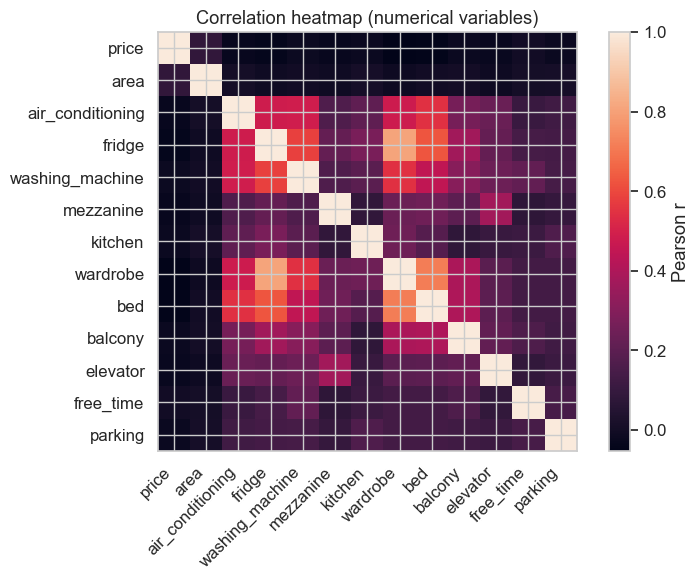

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(corr_matrix.values)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha="right")
ax.set_yticklabels(corr_matrix.index)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Pearson r", rotation=90)

ax.set_title("Correlation heatmap (numerical variables)")
plt.tight_layout()
plt.show()

### **Các cặp biến tương quan mạnh (positive / negative)**

Ta trích xuất các cặp biến có |r| lớn hơn một ngưỡng (ví dụ **0.5**):

- \|r\| ≥ 0.7 → tương quan rất mạnh
- 0.5 ≤ \|r\| < 0.7 → tương quan tương đối mạnh
- 0.3 ≤ \|r\| < 0.5 → tương quan trung bình

Ta sẽ:

1. Lấy phần **tam giác trên** của ma trận tương quan (để không trùng lặp cặp)
2. Sắp xếp theo |r| giảm dần
3. Hiển thị top các cặp tương quan lớn


In [6]:
threshold = 0.5

pairs = []
cols = corr_matrix.columns.tolist()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        c1, c2 = cols[i], cols[j]
        r = corr_matrix.loc[c1, c2]
        pairs.append((c1, c2, r, abs(r)))

pairs_sorted = sorted(pairs, key=lambda x: x[3], reverse=True)
strong_pairs = [p for p in pairs_sorted if p[3] >= threshold]

strong_df = pd.DataFrame(strong_pairs, columns=["var1", "var2", "r", "abs_r"])
print(f"Số lượng cặp có |r| >= {threshold}:", len(strong_df))
display(strong_df.head(20))

Số lượng cặp có |r| >= 0.5: 6


,var1,var2,r,abs_r
0,fridge,wardrobe,0.807630,0.807630
1,wardrobe,bed,0.715649,0.715649
2,fridge,bed,0.628290,0.628290
3,fridge,washing_machine,0.582287,0.582287
4,washing_machine,wardrobe,0.547113,0.547113
5,air_conditioning,bed,0.545752,0.545752


### **Phân tích & Nhận xét**
### **1. Tổng quan**
- Nhìn qua ma trận tương quan giữa các tiện ích (`air_conditioning`, `fridge`, `washing_machine`, `mezzanine`, `kitchen`, `wardrobe`, `bed`, `balcony`, `elevator`, `free_time`, `parking`) và các biến số (`price`, `area`) cho thấy cấu trúc phân khúc rất rõ ràng trong thị trường phòng trọ/căn hộ.
- Dữ liệu phản ánh **3 phân khúc** chính:
  1. **Phòng trọ cơ bản / bình dân** – ít tiện ích.  
  2. **Phòng trọ full nội thất** – nhiều tiện ích đi kèm nhau.  
  3. **Căn hộ mini / Chung cư** – đặc trưng bởi balcony, elevator, washing_machine.

Việc hiểu cấu trúc này giúp xác định hướng feature engineering và mô hình phù hợp.

### **2. Key Correlation Findings**

##### **2.1 Price & Area: Weak Correlation**
 - `price` ↔ amenities: **–0.04 đến 0.05** → gần như không liên quan.
 - `area` ↔ amenities: **≈ 0**.
 - `price` ↔ `area`: **0.085** (rất yếu).

 **Điều này cho thấy tiện ích & diện tích không phải yếu tố quyết định giá** (giá chủ yếu phụ thuộc *địa điểm*, ...):
  * **Giá không tăng rõ ràng khi thêm tiện ích:**
    * Việc có `air_conditioning`, `washing_machine`, `kitchen`, `balcony`... không làm hệ số tương quan với `price` tăng lên đáng kể. Điều này chứng tỏ **vị trí, phân khúc, quận/huyện, chất lượng tòa nhà** quan trọng hơn nhiều so với việc chỉ có thêm 1–2 tiện ích vì chẳng ai muốn phòng trọ cách nơi học tập/làm việc hàng cây số, vừa kẹt xe vừa phải tốn thời gian di chuyển.
  * **Diện tích (`area`) cũng không phải yếu tố duy nhất quyết định giá:**
    * Trong dataset này, diện tích không áp đảo về tương quan giá. Có thể do:
        * Phòng nhỏ nhưng **vị trí siêu đẹp, full nội thất** thì giá vẫn đắt.
        * Phòng lớn nhưng **xa trung tâm, nội thất cơ bản** thì giá rẻ hơn.
    * **Liên hệ thực tế:** Đi xem trọ ở Sài Gòn, ta sẽ thấy thực tế đúng y chang dữ liệu: Một phòng **15–20m²** ở trung tâm, nội thất full, đôi khi đắt hơn hẳn căn **30–40m²** ở ngoại thành, bất chấp diện tích nhỏ hơn nhiều.

##### **2.2 "Full Furnished Cluster" – Cụm nội thất mạnh**
  Các tiện ích nội thất có tương quan mạnh:
 
  | Cặp | r |
  |------|------|
  | fridge ↔ wardrobe | **0.8076** |
  | bed ↔ wardrobe | **0.7156** |
  | bed ↔ fridge | **0.6283** |
  | washing_machine ↔ fridge | 0.5823 |
  | air_conditioning ↔ bed | 0.5457 |
  | air_conditioning ↔ fridge | 0.48 |
  | wardrobe ↔ kitchen | 0.246 |
 
  Tồn tại một **phân khúc rõ rệt**: phòng full nội thất. Nghĩa là khi người chủ họ trang bị nội thất thì xu hướng chung sẽ trang bị full combo đầy đủ chứ không chỉ trang bị nội thất đơn lẻ hay nói cách khác khi một phòng đã có tủ lạnh, thì gần như chắc chắn cũng có tủ quần áo + giường, và khả năng cao có máy lạnh + máy giặt.

##### **2.3 “Apartment Cluster” – Balcony, Elevator, Parking**
 Ở nhóm này, tương quan không mạnh như **full nội thất**, nhưng vẫn có một số mức đáng chú ý trong khoảng **0.2–0.4**:
  | Cặp | r |
  |------|------|
  | balcony ↔ bed | **~0.40** |
  | balcony ↔ wardrobe | **~0.39** |
  | balcony ↔ fridge | **~0.37** |
  | elevator ↔ mezzanine | **~0.37** |
  | balcony ↔ washing_machine | ~0.31 |
  | elevator ↔ washing_machine | ~0.24 |
  | balcony ↔ elevator | ~0.22 |
  | free_time ↔ washing_machine / fridge / kitchen | ~0.14–0.21 |
  | parking ↔ washing_machine | ~0.14 |
  | parking ↔ air_conditioning | ~0.13 |
  
  **Có thể nói rằng:**
   * **Dấu hiệu của phòng trọ dạng 'Căn hộ / Chung cư mini':** Những phòng có **ban công** thường cũng là phòng có **giường, tủ, tủ lạnh, máy giặt** cho thấy nhiều khả năng là căn hộ hoặc chung cư mini, chứ không phải phòng trọ nhỏ lẻ vì nhà trọ truyền thống thông thường sẽ hiếm khi có được ban công mà chỉ là các dãy phòng.
   * **Gói tiện ích gắn liền:** **Thang máy** thường đi kèm máy giặt, tủ lạnh, nội thất, điều này càng củng cố việc đây là một phân khúc phòng trọ dạng 'Căn hộ / chung cư mini'. Vì thông thường các căn hộ / chung cư mini sẽ có nhiều tầng nên sẽ trang bị thêm thang máy.
   * *Funfact: "Nếu phòng có **ban công + thang máy + máy giặt** thì **90%** khả năng cao là căn hộ mini / chung cư chứ không phải phòng trọ truyền thống như hồi xưa."*

##### **2.4 Mezzanine (gác lửng)**
 Mezzanine tương quan **dương nhẹ** với:
  - washing_machine: 0.16  
  - fridge: 0.22  
  - wardrobe: 0.23  
  - elevator: **0.37** (khá cao so với các cặp trong bộ dữ liệu)  

  Điều này cho thấy dataset chứa **cả phòng trọ gác truyền thống** lẫn **căn hộ duplex có gác**. Feature này xuất hiện ở hai phân khúc giá hoàn toàn khác nhau, khiến nó không thể được hiểu theo một chiều, không thể kết luận: “Có gác” = phòng rẻ hoặc “Có gác” = phòng cao cấp, ta cần kết hợp mezzanine với các tiện ích khác để phân loại đúng phân khúc. Điều này giải thích vì sao mezzanine lại có tương quan dương với nhiều tiện ích nội thất với một giá trị trung bình thấp và tương đối cao với elevator.

##### **2.5 Tự do giờ giấc đi kèm tiện nghi**
 Tự do ra vào, không nghiêm nghặt giờ giấc cũng là 1 feature thú vị khi có mức tương quan nhẹ so với các tiện ích:
 | Cặp | r |
 |------|------|
 | free_time ↔ washing_machine | ~0.22 |
 | free_time ↔ parking | ~0.15 |
 | free_time ↔ fridge | ~0.14 |
 | free_time ↔ kitchen | ~0.12 |
 | free_time ↔ air_conditioning | ~0.11 |
 **Điều này cho thấy:**
  * **Phòng tự do giờ giấc có xu hướng:**
     * Tiện nghi hơn.
     * Có nội thất tốt hơn.
     * Có chỗ để xe đàng hoàng.
  * **Điều này hợp lý vì:**
     * Những nhà khó tính / chung chủ thường sẽ giới nghiêm giờ giấc.
     * Loại hình phòng bị giới nghiêm thường bình dân hơn và ít tiện ích hơn vì những người chủ nhà đang "dư" phòng nên "sẳn tiện" cho thuê.

##### **2.6 Không có hệ số tương quan âm mạnh**
 Trong toàn bộ ma trận, hầu như không xuất hiện hệ số tương quan âm lớn (chỉ quanh −0.00x → −0.05). Điều này cho thấy:
 - Các tiện ích không loại trừ lẫn nhau (không có chuyện có cái này thì mất cái kia).
 - Không tồn tại mối quan hệ “nghịch chiều” rõ rệt giữa bất kỳ cặp biến nào.
 - Các tiện ích được trang bị tự do tuỳ vào chủ trọ, phù hợp thực tế: khi chủ đã trang bị nội thất thì thường trang bị nhiều món cùng lúc.
 - Ý nghĩa: Trong context phòng trọ, việc không có tương quan âm mạnh là điều hợp lý, vì tiện ích thường được thêm theo dạng “combo", chỉ tăng lên chứ không triệt tiêu nhau.

### **3. Kết luận**

 1. **Các tiện ích không xuất hiện đơn lẻ**
    * Không có tương quan âm mạnh, các tiện ích không triệt tiêu nhau mà xuất hiện theo cluster. Có một cụm **“full nội thất”**: `AC`, `fridge`, `washing_machine`, `kitchen`, `wardrobe`, `bed`. 
    * **Điều này gợi mở cho ta một điều:** có thể feature engineering thành 1 feature mới: `num_amenities` hoặc `is_full_furnished`.

 2. **Giá và diện tích gần như độc lập với tiện ích**
    * Nếu muốn model dự đoán giá tốt, bắt buộc phải thêm các biến về **địa điểm (address)**, **loại nhà**, v.v.
    * Không thể chỉ dựa vào `amenities` + `area` vì hệ số tương quan lẫn thực tế ngoài đời cho ta thấy rõ được điều đó.

 3. **Balcony + Elevator + Machine = Hơi hướng căn hộ**
    * Combo này là dấu hiệu nhận biết dạng **“chung cư mini / căn hộ dịch vụ”** cũng có thể feature engineering từ đây.

 4. **Mezzanine (Gác) trong dataset mang tính lưỡng cực**
    * Dữ liệu cho thấy sự tồn tại song song của cả **phòng trọ gác truyền thống** lẫn **căn hộ duplex trang bị nội thất**.

 5. **`free_time` là tín hiệu tốt của “chủ dễ tính thì ở thoải mái”**
    * Khi feature engineering, có thể xem đây là 1 tín hiệu để đánh giá 'môi trường' ở thoải mái.

---

## **3. Cross-tabulations**

### 3.1. Categorical × Categorical: Địa bàn (`address`) × Tiện ích

Trong phần này, ta phân tích mối quan hệ giữa **khu vực địa lý** và **các tiện ích** của phòng trọ.

- Cột `address` đã được chuẩn hoá để thể hiện **quận/huyện + tỉnh/thành phố**, ví dụ:  
  - `"Quận Bình Thạnh, TP.HCM"`  
  - `"Quận Gò Vấp, TP.HCM"`  
  - `"Thành phố Thủ Đức, TP.HCM"`  
- Cột `location` chỉ là text raw dùng để trích xuất, **không dùng trực tiếp** cho phân tích.

Các tiện ích được mã hoá dạng nhị phân (0/1):

- `air_conditioning` – có máy lạnh  
- `fridge` – có tủ lạnh  
- `washing_machine` – có máy giặt  
- `mezzanine` – có gác lửng  
- `kitchen` – có bếp  
- `wardrobe` – có tủ quần áo  
- `bed` – có giường  
- `balcony` – có ban công  
- `elevator` – có thang máy  
- `free_time` – giờ giấc tự do (không giới hạn giờ ra vào)  
- `parking` – có chỗ để xe miễn phí

Mục tiêu của phần này:

1. Thống kê tần suất xuất hiện của từng **địa bàn (`address`)**:
   - Xem **top 10 địa bàn có nhiều tin nhất**.
   - Xem **top 10 địa bàn có ít tin nhất** (các khu vực hiếm, ít dữ liệu).
2. Chọn nhóm **top 10 địa bàn có nhiều tin nhất** để phân tích chi tiết (giảm nhiễu do địa bàn quá ít mẫu).
3. Với mỗi tiện ích, tính **tỷ lệ % phòng có tiện ích** đó theo từng địa bàn trong nhóm top này.
4. Ghép lại thành một **bảng tổng hợp**:  
   - Dòng: địa bàn (address).  
   - Cột: % phòng có từng tiện ích.  
5. Tạo thêm một **bảng tóm tắt**: với mỗi tiện ích, cho biết:
   - Địa bàn có tỷ lệ có tiện ích **cao nhất**.  
   - Địa bàn có tỷ lệ có tiện ích **thấp nhất**.  
6. Trực quan hoá bằng **biểu đồ cột** cho từng tiện ích.

### **Thống kế số lượng tin theo địa bàn**

In [7]:
district_col = "address"

# Danh sách tiện ích
amenity_cols = [
    "air_conditioning",
    "fridge",
    "washing_machine",
    "mezzanine",
    "kitchen",
    "wardrobe",
    "bed",
    "balcony",
    "elevator",
    "free_time",
    "parking",
]

# Giữ lại những cột tiện ích thực sự tồn tại trong df
amenity_cols = [c for c in amenity_cols if c in df.columns]
print("Các tiện ích tìm thấy trong dataset:", amenity_cols)

# Thống kê số lượng tin theo địa bàn (bỏ NaN nếu có)
district_counts = df[district_col].dropna().value_counts()

# Top 10 địa bàn có nhiều tin nhất
top10_most = district_counts.nlargest(10)

# Top 10 địa bàn có ít tin nhất
top10_least = district_counts.nsmallest(10)

print("\nTop 10 địa bàn có nhiều tin nhất:")
display(top10_most)

print("\nTop 10 địa bàn có ít tin nhất:")
display(top10_least)

# Dữ liệu con dùng cho phân tích chi tiết 
df_top = df[df[district_col].isin(top10_most.index)].copy()

# Tổng số tin toàn dataset
total_posts = len(df)

# Số tin thuộc top 10 địa bàn nhiều tin
top10_posts = top10_most.sum()

# Tỷ lệ %
top10_ratio = top10_posts / total_posts * 100

print(f"Tổng số tin toàn bộ dataset: {total_posts}")
print(f"Số tin tại Top 10 địa bàn nhiều tin nhất: {top10_posts}")
print(f"Tỷ lệ chiếm: {top10_ratio:.2f}%")

Các tiện ích tìm thấy trong dataset: ['air_conditioning', 'fridge', 'washing_machine', 'mezzanine', 'kitchen', 'wardrobe', 'bed', 'balcony', 'elevator', 'free_time', 'parking']

Top 10 địa bàn có nhiều tin nhất:


address
Quận Bình Thạnh - Hồ Chí Minh    3103
Quận Tân Bình - Hồ Chí Minh      2829
Quận Gò Vấp - Hồ Chí Minh        2226
Quận Tân Phú - Hồ Chí Minh       1691
Quận 7 - Hồ Chí Minh             1310
Quận 12 - Hồ Chí Minh            1065
Quận 10 - Hồ Chí Minh            1060
Quận Bình Tân - Hồ Chí Minh      1057
Quận 9 - Hồ Chí Minh             1016
Quận Phú Nhuận - Hồ Chí Minh      872
Name: count, dtype: int64


Top 10 địa bàn có ít tin nhất:


address
Huyện Châu Thành Hậu Giang - Hậu Giang    1
Thành phố Hà Giang - Hà Giang             1
Huyện Diên Khánh - Khánh Hòa              1
Thị xã Điện Bàn - Quảng Nam               1
Huyện Nhơn Trạch - Đồng Nai               1
Huyện Lai Vung - Đồng Tháp                1
Huyện Mỹ Hào - Hưng Yên                   1
Huyện Phù Cát - Bình Định                 1
Thành Phố Đông Hà - Quảng Trị             1
Thành Phố Bà Rịa - Bà Rịa - Vũng Tàu      1
Name: count, dtype: int64

Tổng số tin toàn bộ dataset: 24121
Số tin tại Top 10 địa bàn nhiều tin nhất: 16229
Tỷ lệ chiếm: 67.28%


#### **Nhận xét về số lượng tin đăng theo địa bàn**

#### 1. Top 10 địa bàn có nhiều tin đăng nhất
**Danh sách bao gồm:**
* Quận Bình Thạnh – Hồ Chí Minh (3103 tin)
* Quận Tân Bình – Hồ Chí Minh (2829 tin)
* Quận Gò Vấp – Hồ Chí Minh (2226 tin)
* Quận Tân Phú – Hồ Chí Minh (1691 tin)
* Quận 7 – Hồ Chí Minh (1310 tin)
* Quận 12 – Hồ Chí Minh (1065 tin)
* Quận 10 – Hồ Chí Minh (1060 tin)
* Quận Bình Tân – Hồ Chí Minh (1057 tin)
* Quận 9 – Hồ Chí Minh (1016 tin)
* Quận Phú Nhuận – Hồ Chí Minh (872 tin)

**Nhận xét:**
* **Tất cả top 10 địa bàn đều thuộc TP. Hồ Chí Minh**, không có quận/huyện nào từ Hà Nội hay tỉnh khác lọt vào top → điều này phản ánh:
    * Hồ Chí Minh là thị trường thuê nhà sôi động nhất Việt Nam.
    * Mức độ số hóa tin đăng, nhu cầu thuê – cho thuê cao hơn hẳn các địa phương khác.
* **Những quận đứng đầu như Bình Thạnh, Tân Bình, Gò Vấp đều là:**
    * Khu dân cư đông đúc.
    * Tập trung nhiều sinh viên, người lao động, văn phòng, dẫn đến nhu cầu thuê trọ/nhà cực kỳ lớn.
    * Rất nhiều khu trọ lâu đời, giá đa dạng, dễ tiếp cận.
* **Bình Thạnh và Tân Bình đặc biệt nổi bật:**
    * Bình Thạnh sát Quận 1, gần các trường đại học lớn (Hutech, Hồng Bàng, Văn Lang…)
    * Tân Bình gần sân bay Tân Sơn Nhất, nhiều công ty – văn phòng.
    * Đây là hai quận truyền thống có lượng phòng trọ nhiều nhất TP.HCM.
* **Quận 7, Quận 12 và Quận 9 lọt top nhờ:**
    * Quận 7: khu đô thị phát triển → nhiều chung cư mini, căn hộ dịch vụ.
    * Quận 12 và Quận 9: vùng giáp ranh TP Thủ Đức, dân số trẻ tăng nhanh, lượng trọ xây mới nhiều.

#### 2. Top 10 địa bàn có ít tin đăng nhất
**Tất cả đều chỉ có 1 tin, gồm các huyện/thị xã ở:**
→ Hậu Giang, Hà Giang, Đồng Nai, Bạc Liêu, Bình Định, Quảng Trị, Bà Rịa – Vũng Tàu,…

**Nhận xét:**
* **Các địa phương này đa phần là huyện – thị xã ở tỉnh**, không phải các thành phố lớn.
* **Điều này hoàn toàn hợp lý vì:**
    * Nhu cầu thuê nhà ở nông thôn rất thấp.
    * Người dân thường có đất và nhà riêng, ít cần phải thuê trọ.
    * Khi có nhu cầu thuê nhà, thường giao dịch trực tiếp, ít đăng tin online.
* **Tính số hóa của thị trường thấp:**
    * Nhiều tỉnh chưa phổ biến việc đăng tin cho thuê lên các nền tảng. Chủ nhà thường:
        * Treo bảng giấy.
        * Nhờ người quen giới thiệu.
        * Đăng trong nhóm Facebook địa phương, không lên website aggregator.
    * Dữ liệu ở các tỉnh trải dài nhưng mỗi nơi chỉ xuất hiện 1 tin => cho thấy nền tảng thu thập dữ liệu vẫn có độ bao phủ toàn quốc nhưng mật độ thấp ở vùng ít nhu cầu.
* **Đây có thể là noise trong dữ liệu:**
    * Một số tỉnh có thể chỉ xuất hiện vì trỏ sai địa chỉ, sai tỉnh, hoặc format không đồng nhất.
    * Cần kiểm tra xem địa chỉ đầy đủ có bị parsing lỗi không.

#### 3. Liên hệ thực tế
* **Bức tranh thị trường rất rõ ràng:**
    * TP. Hồ Chí Minh chiếm ưu thế tuyệt đối, đặc biệt là các quận nội thành như Bình Thạnh, Tân Bình, Gò Vấp.
    * Các địa phương tỉnh/thành khác hầu như không có sự hiện diện đáng kể.
* **Phân bố số lượng tin phản ánh đúng đặc trưng kinh tế – xã hội:**
    * Nơi dân đông, nhiều trường đại học, văn phòng → nhiều người thuê → nhiều tin đăng.
    * Vùng nông thôn → nhu cầu thấp → số lượng tin rất ít.
* **Dữ liệu thể hiện mức độ phát triển đô thị:**
    * Khu vực phát triển mạnh (TP.HCM) có mức độ số hóa, đăng tin online rất cao.
    * Các tỉnh miền Tây, miền núi phía Bắc, miền Trung → số hóa thấp.
* **Điều này dẫn đến:**
    * Khi vẽ heatmap hay phân tích tiện ích theo quận ta sẽ phân tích nhóm top 10–15 quận.
    * Không nên gom huyện ít tin vì:
        * không đủ mẫu,
        * dễ gây nhiễu thống kê.
    * Có thể làm thêm phân tích “độ đa dạng tiện ích theo vùng”.

### **Thống kê tiện ích theo top địa bàn**

In [8]:
# Bảng tổng hợp: Phần trăm phòng có từng tiện ích theo địa bàn (top 10 nhiều tin nhất)
district_amenities_pct = (
    df_top
    .groupby(district_col)[amenity_cols]
    .mean(numeric_only=True)   
    .mul(100)                   
    .reindex(top10_most.index) 
    .round(2)
)
k = 10

print(f"Bảng tổng hợp: Phần trăm phòng có từng tiện ích theo địa bàn (top {k} nhiều tin nhất):")
display(district_amenities_pct)

# Hàm tóm tắt cho 1 tiện ích
def summarize_amenity(col_ser: pd.Series) -> pd.Series:
    """
    Tóm tắt 1 cột tiện ích:
    - Nếu toàn NaN → trả 'Không có dữ liệu'
    - Ngược lại → lấy địa bàn max, min và % tương ứng.
    """
    s = col_ser.dropna()
    if s.empty:
        return pd.Series({
            "max_address": "Không có dữ liệu",
            "max_pct":     np.nan,
            "min_address": "Không có dữ liệu",
            "min_pct":     np.nan,
        })
    return pd.Series({
        "max_address": s.idxmax(),
        "max_pct":     s.max(),
        "min_address": s.idxmin(),
        "min_pct":     s.min(),
    })

summary_amenities = (
    district_amenities_pct
    .apply(summarize_amenity, axis=0)  # mỗi cột (amenity) là 1 dòng summary
    .T                                 # tiện ích sẽ được đưa thành từng dòng
    .reset_index(names="amenity")
    .sort_values("max_pct", ascending=False)
)

print("\nĐịa bàn có tỷ lệ tiện ích cao nhất / thấp nhất cho từng tiện ích:")
display(summary_amenities.round(2))

Bảng tổng hợp: Phần trăm phòng có từng tiện ích theo địa bàn (top 10 nhiều tin nhất):


,air_conditioning,fridge,washing_machine,mezzanine,kitchen,wardrobe,bed,balcony,elevator,free_time,parking
address,,,,,,,,,,,
Quận Bình Thạnh - Hồ Chí Minh,91.14,81.24,90.27,92.59,84.69,74.54,78.05,86.30,97.78,86.66,83.11
Quận Tân Bình - Hồ Chí Minh,91.91,77.77,88.23,93.04,81.37,72.53,76.21,86.67,97.99,84.09,82.36
Quận Gò Vấp - Hồ Chí Minh,93.13,83.29,91.46,93.53,84.55,78.93,80.64,89.31,98.74,85.85,82.88
Quận Tân Phú - Hồ Chí Minh,91.84,79.89,89.65,93.38,81.08,74.33,78.30,89.41,98.64,87.29,83.21
Quận 7 - Hồ Chí Minh,90.61,81.15,89.39,95.11,86.64,73.82,77.02,85.34,98.17,89.31,87.10
Quận 12 - Hồ Chí Minh,95.12,83.47,91.74,92.86,81.22,79.62,82.54,90.61,99.06,83.19,88.45
Quận 10 - Hồ Chí Minh,92.45,83.11,90.57,94.81,88.21,75.75,80.28,89.91,98.96,87.74,87.26
Quận Bình Tân - Hồ Chí Minh,92.90,82.02,90.63,93.57,82.78,77.11,80.61,87.70,98.86,86.19,81.55
Quận 9 - Hồ Chí Minh,95.28,86.22,91.73,96.26,87.11,81.50,85.14,95.37,99.02,93.21,88.48



Địa bàn có tỷ lệ tiện ích cao nhất / thấp nhất cho từng tiện ích:


,amenity,max_address,max_pct,min_address,min_pct
8,elevator,Quận 12 - Hồ Chí Minh,99.06,Quận Bình Thạnh - Hồ Chí Minh,97.78
3,mezzanine,Quận 9 - Hồ Chí Minh,96.26,Quận Bình Thạnh - Hồ Chí Minh,92.59
7,balcony,Quận 9 - Hồ Chí Minh,95.37,Quận 7 - Hồ Chí Minh,85.34
0,air_conditioning,Quận 9 - Hồ Chí Minh,95.28,Quận Phú Nhuận - Hồ Chí Minh,86.7
9,free_time,Quận 9 - Hồ Chí Minh,93.21,Quận 12 - Hồ Chí Minh,83.19
2,washing_machine,Quận 12 - Hồ Chí Minh,91.74,Quận Phú Nhuận - Hồ Chí Minh,88.19
10,parking,Quận 9 - Hồ Chí Minh,88.48,Quận Bình Tân - Hồ Chí Minh,81.55
4,kitchen,Quận 10 - Hồ Chí Minh,88.21,Quận Tân Phú - Hồ Chí Minh,81.08
1,fridge,Quận 9 - Hồ Chí Minh,86.22,Quận Tân Bình - Hồ Chí Minh,77.77
6,bed,Quận 9 - Hồ Chí Minh,85.14,Quận Tân Bình - Hồ Chí Minh,76.21


### **Visualize**

C:\Users\Phuc Chau\AppData\Local\Temp\ipykernel_11512\970120627.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20")


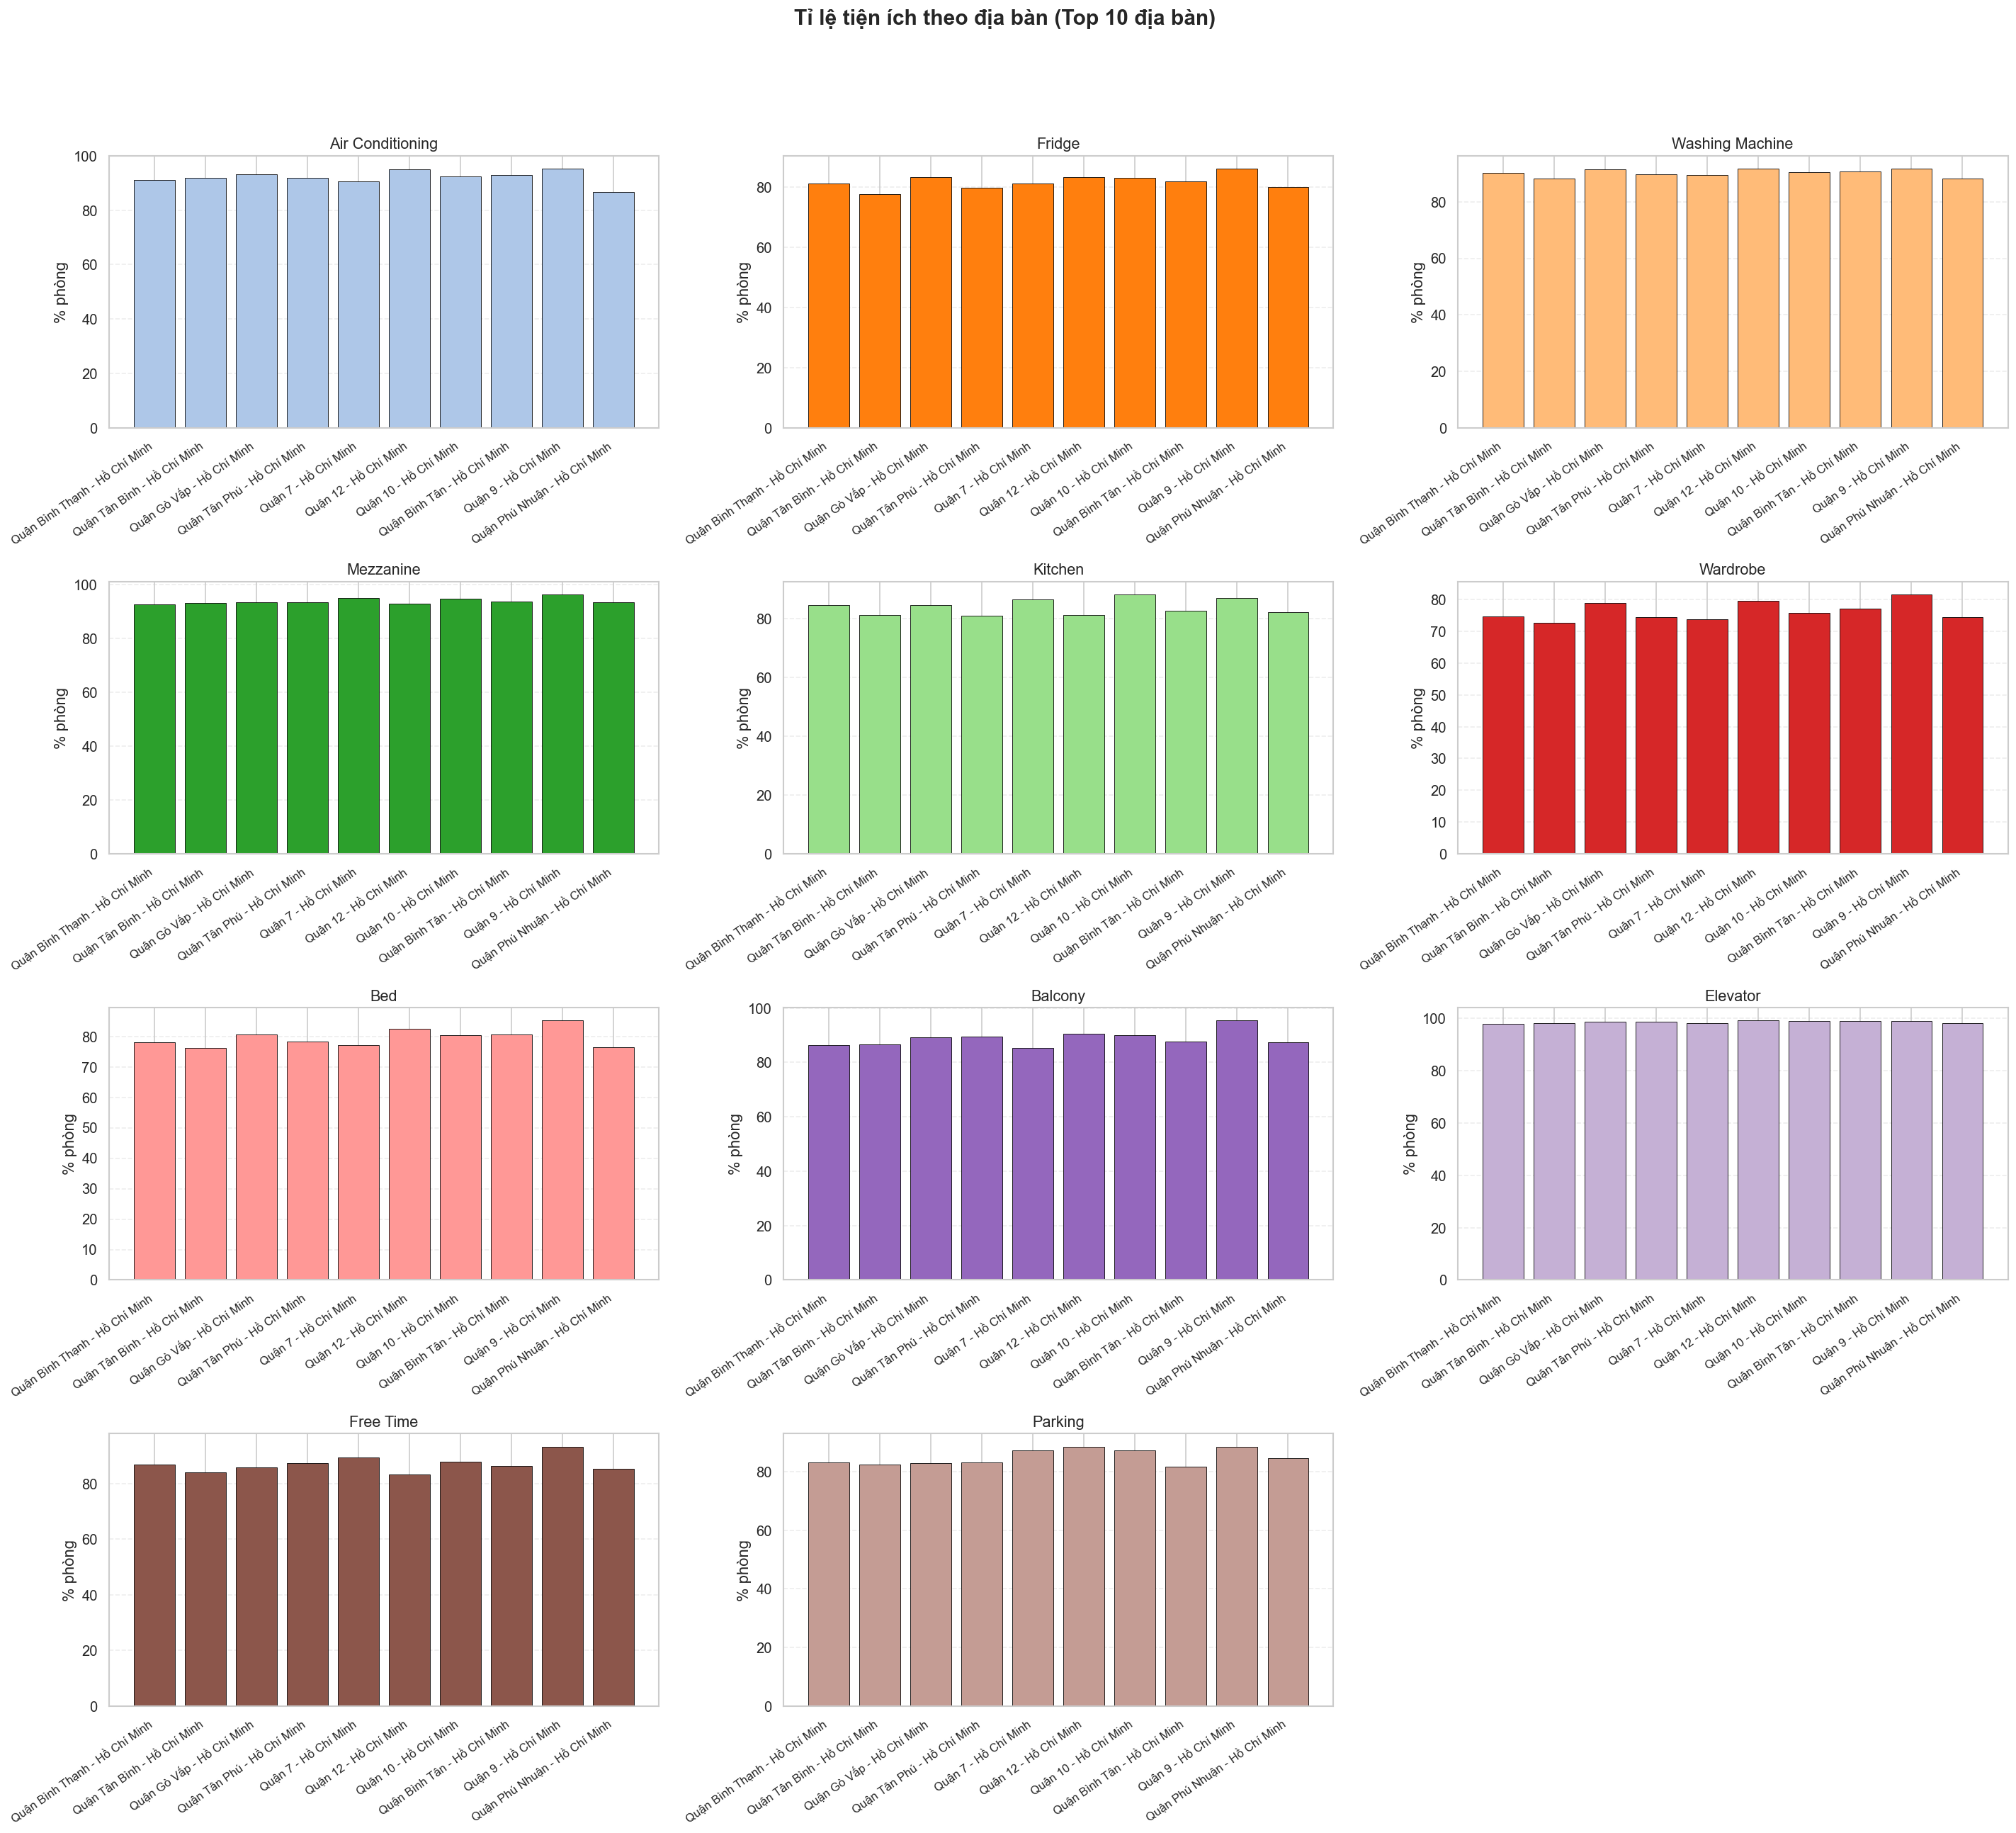

In [9]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

# Lấy danh sách tiện ích hợp lệ trong district_amenities_pct
valid_cols = [col for col in amenity_cols if col in district_amenities_pct.columns]

num_cols = len(valid_cols)
cols_per_row = 3
rows = int(np.ceil(num_cols / cols_per_row))

# Dùng colormap tab20 nhưng giới hạn an toàn bằng modulo
cmap = plt.cm.get_cmap("tab20")

plt.figure(figsize=(cols_per_row * 8, rows * 5.5))
plt.suptitle(
    f"Tỉ lệ tiện ích theo địa bàn (Top {len(district_amenities_pct)} địa bàn)",
    fontsize=18, weight="bold"
)

x = np.arange(len(district_amenities_pct.index))

for i, col in enumerate(valid_cols, 1):
    ax = plt.subplot(rows, cols_per_row, i)

    color = cmap(i % 20)

    ax.bar(
        x,
        district_amenities_pct[col],
        color=color,
        edgecolor="black",
        linewidth=0.5
    )

    ax.set_title(col.replace("_", " ").title(), fontsize=13)

    ax.set_xticks(x)
    ax.set_xticklabels(
        district_amenities_pct.index,
        rotation=35, ha="right", fontsize=10
    )

    ax.set_ylabel("% phòng")
    ax.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### **Phân tích & nhận xét**

#### **1. Bức tranh chung: phòng trọ TP.HCM đang “tiện nghi hóa” cực mạnh**
Khi nhìn các tỷ lệ tiện ích đều dao động **từ hơn 80% đến gần 100%**, cảm giác như: *“Ở Sài Gòn bây giờ, phòng trọ tiện nghi không khác gì nhà ở.”*

**Dữ liệu thực tế cho thấy ở các địa bàn nằm top đầu trong bảng:**

* **Thang máy** luôn trên ~97%, có nơi tới **99.06%** (Quận 12).  
* **Ban công** phần lớn nằm trong khoảng **85–95%**, với đỉnh ~**95.37%** (Quận 9).  
* **Máy lạnh** dao động khoảng **86.7–95.28%**.  
* **Gác lửng, bếp, máy giặt** cũng đều ở mức cao, thường **> 80–90%**.  

**Một sự thật khá bất ngờ:** Phòng *thiếu* tiện ích giờ mới là ngoại lệ, chứ phòng *có* đủ tiện ích không còn là điều gì “sang chảnh” nữa. Không phải chủ trọ thêm tiện ích để “đội giá” cho vui, mà là để bắt kịp mặt bằng chung của thị trường và quan trọng hơn là **không bị loại khỏi cuộc chơi**. Chỉ cần **thiếu** một vài tiện ích cơ bản, phòng rất dễ bị “out” khỏi list lựa chọn của người thuê.

#### **2. Quận ven áp đảo tiện ích – phòng mới nhiều, nhà xây đồng loạt**

**Điểm thú vị là:**
* Các quận như **Quận 9, Quận 12, Tân Phú, Gò Vấp** mới là “vùng đất hứa” của các tiện ích.
* Trong khi đó, các quận trung tâm như **Bình Thạnh, Tân Bình, Phú Nhuận** lại xuất hiện khá nhiều ở cột **min_pct** (tỷ lệ thấp nhất).

**Một vài con số tiêu biểu từ bảng “max/min”:**

* **Quận 9** dẫn đầu rất nhiều tiện ích:
  * Balcony: **95.37%**  
  * Air conditioning: **95.28%**  
  * Free time: **93.21%**  
  * Fridge: **86.22%**  
  * Bed: **85.14%**  
  * Wardrobe: **81.5%**
* **Quận 12** nổi bật ở:
  * Elevator: **99.06%**  
  * Washing machine: **91.74%**
* Ở chiều ngược lại:
  * Wardrobe thấp nhất: **Tân Bình – 72.53%**  
  * Fridge thấp nhất: **Tân Bình – 77.77%**  
  * Parking thấp nhất: **Bình Thạnh – 81.55%**  
  * Free time thấp nhất: **Quận 12 – 83.19%**

**Số liệu đúng theo thực tế:**

* **Quận ven** có quỹ đất rộng, đa số là các phòng được xây mới và xây đồng loạt theo “mẫu phòng hiện đại”, tiện ích đầy đủ là chuyện hiển nhiên, dùng để **bù lại bất lợi về vị trí xa trung tâm**. 
* **Quận trung tâm**:
  * Quỹ đất nhỏ  
  * Nhiều nhà trọ lâu năm. Phòng “từ thời đi xe Cub” vẫn cho thuê được có thể vì chủ trọ không muốn đập đi xây lại vì vẫn còn cho thuê "ngon".  
  * Hẻm nhỏ khó bố trí ban công, thang máy, bãi xe.  

#### **3. Ban công**
* **Cao nhất:** Quận 9 – **95.37%**  
* **Thấp nhất:** Quận 7 – **85.34%**

 **Nhìn vào con số và thực tế:**
  * Quận 9: nhiều phòng studio mới được xây nên việc có ban công gần như mặc định.  
  * Quận 7: có thể giải thích là vì quận 7 vẫn còn tồn tại các phòng trọ "truyền thống" nhiều nên tỉ lệ không bằng các địa bàn trong top nhưng vẫn cao (86.34%).  

#### **4. Gác lửng**
 * **Cao nhất:** Quận 9 – **96.26%**  
 * **Thấp nhất:** Bình Thạnh – **92.59%**

 Nhìn chung thì tỉ lệ có gác trên các địa bàn khá cao đặc biệt là ở vùng ven, tỉ lệ gác lửng ở các quận top 10 đều trên 92%, tức là đa số phòng được thiết kế để “nới” thêm không gian ngủ/học trên gác – rất đặc trưng cho mô hình phòng trọ Sài Gòn.

#### **5. Máy lạnh – từ “xa xỉ phẩm” thành “tiêu chuẩn sống”**
* **Cao nhất:** Quận 9 – **95.28%**  
* **Thấp nhất:** Phú Nhuận – **86.7%**

 Máy lạnh đạt trên 86–95%, một mức cực kỳ cao thậm chí cao hơn so với nhà ở thông thường.

 * **Cách đây 10 năm trước:** Phòng có máy lạnh được xem là “phòng VIP”, hiếm.
 * **Giờ đây:** Phòng không máy lạnh mới là “phòng kỳ lạ”.

#### **6. Máy giặt**
* **Cao nhất:** Quận 12 – **91.74%**  
* **Thấp nhất:** Phú Nhuận – **88.19%**

 Máy giặt 88–91% cho thấy tỉ lệ khá cao và trong thực tế các phòng trọ hiện đại thường lắp máy giặt chung, khá tiện lợi cho người thuê. Máy giặt chung theo tầng là tiêu chuẩn của các tòa trọ xây giai đoạn 2018 trở lại đây.

#### **7. Parking**
* **Cao nhất:** Quận 9 – 88.48%  
* **Thấp nhất:** Bình Tân – 81.55%
Parking thấp nhất Bình Tân (81.55%) vì:
 * Đường nhỏ,
 * Nhà chen nhau,
 * Không gian chật,
 * Giá đât đắt đỏ.
Quận ven rộng rãi, đất rộng nên tỉ lệ chỗ để xe miễn phí cao còn các địa bàn trung tâm hơn thì "tất đất, tất vàng" không gian để xe cũng là một chi phí cao nên các chủ trọ có xu hướng thu tiền đỗ xe nhiều hơn.

#### **8. Bếp**
* **Quận 10 là quận có bếp cao nhất (88.21%):** Nhiều phòng studio mini cho dân văn phòng, sinh viên y dược, các bác sĩ, y tá.
* **Tân Phú thấp nhất (81.08%):** Nhiều dãy trọ truyền thống.
* Phòng có bếp thường rơi vào phân khúc studio / căn hộ mini, hướng đến: Dân văn phòng, sinh viên đi làm thêm, có nhu cầu nấu ăn đều đặn, ở lâu dài.

#### **9. Giường & tủ áo**
* Bed: 76–77%
* Wardrobe: 72–81%
* Tỷ lệ giường và tủ áo thấp hơn rõ rệt so với mặt bằng chung của các tiện ích khác (đa số đều >85–90%). Điều này hoàn toàn hợp lý, vì đây là nhóm nội thất rời, không bắt buộc phải có trong mọi loại phòng. Về mặt thực tế thì đúng là đa số các chủ trọ chỉ trang bị máy lạnh, máy giặt, ... là chủ yếu còn các đồ nội thất trang trí thì họ sẽ để người thuê tự trang trí theo ý muốn. Có thể nói như sau:

“Phòng có giường + tủ = phòng dành cho người bận rộn, muốn vào ở ngay.” **Trong khi:** Phòng không giường/tủ thường nhắm đến người muốn tự trang trí – tự set up, thường rẻ hơn.


#### **Kết luận**
- **Chủ trọ vùng ven đầu tư tiện ích để cạnh tranh:** Vì khu ven có quỹ đất lớn, khi xây phòng mới thì sẽ theo “mẫu hiện đại”.

- **Chủ trọ trung tâm có vị trí đắt đỏ thì thường đầu tư nhiều cho nội thất:** Người thuê vẫn chấp nhận phòng không quá đẹp nhưng gần trung tâm.

- **Tiện ích có xu hướng đồng nhất hóa mạnh:** Sài Gòn đang tiến tới mô hình “phòng chuẩn hóa” như Singapore mini-studio.

- **Tiện ích** giờ đây không còn là công cụ để các chủ trọ tăng giá, mà để nắm bắt xu thế và tạo sự cạnh tranh.

---

### **3.2. Numerical × Categorical: Giá phòng theo địa bàn, tuyến đường và tiện ích**

Trong phần này, ta đi sâu vào biến quan trọng nhất của bài toán: **giá phòng (`price`)**, và xem xét sự khác biệt của nó khi kết hợp với các biến phân loại:

1. **Địa bàn (quận/huyện)** – biểu thị mức độ phát triển, vị trí và mặt bằng thuê chung.  
2. **Tên đường** – yếu tố vi mô (micro-location), ảnh hưởng rất mạnh đến giá.  
3. **Các tiện ích chính** – như `mezzanine`, `balcony`, `elevator`, `parking`, `air_conditioning`, `kitchen`, …  

Mục tiêu của phần này:

- Hiểu **quận/huyện nào có mức giá cao/thấp hơn** trong nhóm top 10 nhiều tin nhất.  
- Nhận diện các **tuyến đường “đắt đỏ”** khi phân tích theo cặp *(address, street_name)*.  
- So sánh **giá giữa nhóm phòng có / không có tiện ích**, xem tiện ích nào có xu hướng kéo giá lên.  
- Xác định các đặc điểm vị trí và tiện ích có thể dùng làm **feature mạnh** cho mô hình dự đoán giá (feature engineering).  

Kết quả của mục 3.2 không chỉ mô tả thị trường mà còn giúp định hướng rõ ràng cho bước modeling:  
- Tạo feature theo quận  
- Tạo feature theo tuyến đường  
- Tạo feature tương tác giữa vị trí và tiện ích  
- Giảm nhiễu khi encode dữ liệu có cardinality cao

#### **Chuẩn bị**

In [10]:
# Các cột chính
price_col = "price"
district_col = "address"
street_col = "street_name"

# Kiểm tra tồn tại
assert district_col in df.columns
assert street_col in df.columns
assert price_col in df.columns

# Detect cột area nếu có
has_area = "area" in df.columns

# Chọn cột cần thiết
cols_keep = [district_col, street_col, price_col] + amenity_cols
if has_area:
    cols_keep.append("area")
cols_keep = [c for c in cols_keep if c in df.columns]

df_price = df[cols_keep].copy()

# Lọc các dòng có giá hợp lệ
df_price = df_price[df_price[price_col].notna()].copy()

print("Số dòng còn lại sau khi lọc giá:", len(df_price))

Số dòng còn lại sau khi lọc giá: 24062


### **3.2.1. Giá phòng theo địa bàn (Top 10 nhiều tin nhất)**

Ở mục 3.1 ta đã xác định `top10_most`: danh sách 10 địa bàn có số lượng tin nhiều nhất.  
Ở đây, ta phân tích giá của những địa bàn này để xem:

- Địa bàn nào có **median price** cao nhất?  
- Sự chênh lệch giữa các địa bàn lớn hay nhỏ?  
- Các quận ven – trung tâm khác nhau như thế nào về giá?

Điều này đặc biệt quan trọng cho modeling vì `address` là một feature cực mạnh.

Note: Vì sao xét median mà không xét mean: Dữ liệu giá phòng có phân phối lệch phải mạnh và tồn tại nhiều outlier lớn (max = 260 triệu). Do đó, median được chọn làm giá trị đại diện vì phản ánh đúng mức giá phổ biến.

In [11]:
target_districts = df_price[district_col].value_counts().nlargest(10).index

df_district = df_price[df_price[district_col].isin(target_districts)].copy()

def q25(x): return x.quantile(0.25)
def q75(x): return x.quantile(0.75)

price_by_district = (
    df_district
    .groupby(district_col)[price_col]
    .agg(
        count="size",
        mean="mean",
        median="median",
        q25=q25,
        q75=q75,
        min="min",
        max="max",
    )
    .sort_values("median", ascending=False)
    .round(0)
)

print("Giá phòng theo top địa bàn:", end='')
display(
    price_by_district.style
        .format("{:,.0f}")     
        .set_properties(**{
            "text-align": "center",
            "font-size": "13px"
        })
        .set_table_styles([
            dict(selector="th", props=[
                ("text-align", "center"),
                ("font-weight", "bold"),
            ])
        ])
)


Giá phòng theo top địa bàn:

,count,mean,median,q25,q75,min,max
address,,,,,,,
Quận Bình Thạnh - Hồ Chí Minh,"3,098",5,5,4,6,1,27
Quận 10 - Hồ Chí Minh,"1,057",4,4,3,5,1,12
Quận Phú Nhuận - Hồ Chí Minh,871,4,4,4,6,1,14
Quận 7 - Hồ Chí Minh,"1,306",4,4,4,5,1,48
Quận Tân Bình - Hồ Chí Minh,"2,828",4,4,3,4,0,29
Quận Gò Vấp - Hồ Chí Minh,"2,223",4,4,3,4,0,28
Quận Tân Phú - Hồ Chí Minh,"1,688",4,4,3,4,0,23
Quận 9 - Hồ Chí Minh,"1,009",3,3,2,4,0,20
Quận 12 - Hồ Chí Minh,"1,065",3,3,2,4,1,10


##### **Visualize**

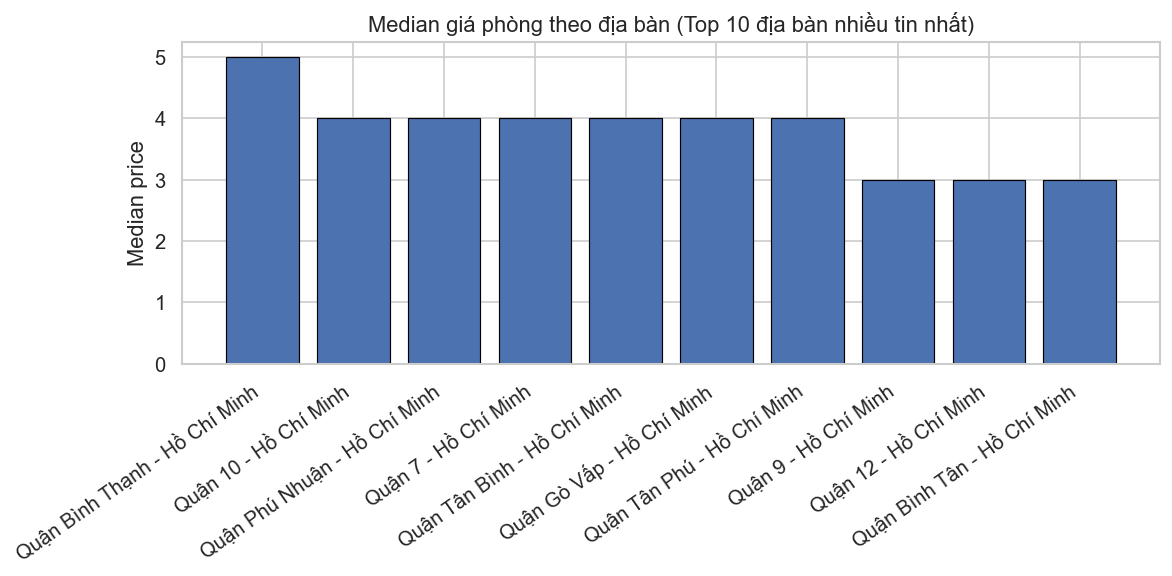

In [12]:
plt.figure(figsize=(10, 5))

median_sorted = price_by_district["median"]

plt.bar(
    median_sorted.index,
    median_sorted.values,
    edgecolor="black",
    linewidth=0.7,
)

plt.xticks(rotation=35, ha="right")
plt.ylabel("Median price")
plt.title("Median giá phòng theo địa bàn (Top 10 địa bàn nhiều tin nhất)")
plt.tight_layout()
plt.show()

### **Phân tích & nhận xét**

#### **1. Tổng quan**

Bảng thống kê giá phòng theo địa bàn cho thấy sự khác biệt rõ rệt giữa **khu trung tâm** và **khu ven** của TP.HCM. Dữ liệu bao gồm các chỉ số: *median, mean, q25, q75, min, max*, giúp nhận diện mặt bằng giá và độ phân tán của từng khu vực.

#### **2. Bình Thạnh dẫn đầu về median price (5 triệu)**

- **Median = 5 triệu**, cao nhất trong nhóm.
- Khoảng giá khá hẹp (q25 = 4 → q75 = 6), cho thấy mức giá **ổn định**.
- Tuy nhiên, **max = 27 triệu**, phản ánh có sự hiện diện của phân khúc cao cấp (studio, căn hộ mini ở khu D2 – D3 – gần Landmark).

**Kết luận:** Bình Thạnh là quận “đa phân khúc”, nhưng nhóm trung–cao cấp chiếm ưu thế.

#### **3. Các quận trung tâm khác: Phú Nhuận, Quận 7, Quận 10** (median = 4 triệu)
Dù cùng median = 4 triệu nhưng lại có sự khác biệt:
- **Quận 7:** max = 48 → phân khúc rất rộng, từ phòng giá rẻ đến căn hộ cao cấp ở Phú Mỹ Hưng.
- **Phú Nhuận:** max = 14 → ít phòng cao cấp, giá tập trung.
- **Quận 10:** max = 12 → phân phối ổn định hơn.

**Kết luận:** Median giống nhau không có nghĩa phân khúc giống nhau, ta cần quan sát thêm biên độ.

#### **4. Nhóm quận ven (Gò Vấp, Tân Bình, Tân Phú, Quận 9, Quận 12, Bình Tân)** – median = 3 triệu

Tất cả quận ven đều có median = 3 triệu nhưng khác biệt đáng chú ý:

##### Gò Vấp 
- Biên độ (q25=3 → q75=4) khá “ổn định”. 
- Max = 28 vẫn xuất hiện phòng cao cấp.

##### Tân Phú
- Min = 0 đây là giá lỗi sẽ loại bỏ ở phần processing.  
- Max = 23 vẫn có phòng cao cấp xuất hiện.

##### Quận 9
- (q25 = 4, q75 = 4) cho thấy giá rất ổn định.
- Như đã thống kê bên trên Quận 9 là quận có tiện ích cao nhất nhưng giá mềm, đây là khu vực khá cạnh tranh thu hút nhiều người thuê.

##### Quận 12
- (q25 = 4, q75 = 4) cho thấy giá rất ổn định.
- Max = 26 cho thấy cũng xuất hiện phòng cao cấp.

##### Bình Tân
- (q25 = 4, q75 = 4) cho thấy giá rất ổn định.
- Nhưng **Max = 260** cho thấy đây chắc chắn là **outlier** cần xử lý hoặc có thể là giá lỗi nhập "thừa số 0".

**Kết luận chung:** Khu ven giá khá ổn định và "mềm" cộng thêm tiện ích lại tốt có thể phù hợp làm feature phân khúc "vùng ven". Đồng thời điều này phản ánh một thực trạng khu ven bù lại vị trí xa bằng chất lượng phòng cao.

#### **5. So sánh Trung tâm vs Ven**

#### Trung tâm:
- Median: 4–5 triệu  
- Biên độ rộng  
- Nhiều phòng cao cấp (12–48 triệu)

#### Ven:
- Median: 3 triệu  
- Biên độ thấp hơn, giá ổn định hơn.  
- Một số giá lỗi (sẽ được processing)

#### **6. Ý nghĩa đối với Feature Engineering**

Các feature hữu ích:

- `district_median_price`
- `delta_price_vs_district`
- `is_center_district` (nhóm theo cluster)
- `price_bucket_by_district`

**Lý do:**

- Quận ven dễ “lệch pha” vì có đầy đủ tiện ích nhưng giá thấp.  
- Quận trung tâm thì nhiều outlier giá cao. 
#### **7. Kết luận**
- Bình Thạnh là quận có mặt bằng giá cao nhất.  
- Quận 7 có độ phân tán giá lớn nhất → đa phân khúc mạnh.  
- Quận ven <3 triệu nhưng chất lượng phòng tốt.  
- Một số outlier cần xử lý (đặc biệt là Bình Tân).  
- Feature về **vị trí** là yếu tố **rất quan trọng** trong modeling.

**Cần xử lí (encoding) cẩn thận cho biến address vì đây là một biến ảnh hưởng đến giá thuê.**

---

#### **3.2.2. Giá phòng theo (Địa bàn + Tên đường)**

Phân tích `street_name` *một mình* thường **không có giá trị**, vì:

- Cùng một tên đường có thể xuất hiện ở nhiều quận khác nhau (trùng tên).
- Giá phòng phụ thuộc rất lớn vào **address (quận/huyện)**.
- Một tuyến đường “đắt đỏ” tại Quận 10 có thể có giá thấp nếu cùng tên xuất hiện ở Quận Bình Tân.

Vì vậy, ta phân tích theo **cặp (address, street_name)** — tức là “tuyến đường trong một quận”.

Mục tiêu:

- Xác định tuyến đường nào **đắt nhất trong từng quận**.  
- Và tuyến đường nào **cao hơn mặt bằng chung của chính quận đó** → rất quan trọng cho Feature Engineering:
  - `street_relative_price`
  - `is_high_price_street`
  - `street_median_minus_district_median`

Điều này chính xác hơn rất nhiều so với chỉ xét street_name.

In [13]:
min_ads_street = 15
min_ads_pair = 10

# Lọc street 
street_counts = df_price[street_col].value_counts()
valid_streets = street_counts[street_counts >= min_ads_street].index

df_street = df_price[df_price[street_col].isin(valid_streets)].copy()

# Build aggregator
group_stats = {
    "count": ("price", "size"),
    "mean_price": ("price", "mean"),
    "median_price": ("price", "median"),
    "q25": ("price", q25),
    "q75": ("price", q75),
    "min_price": ("price", "min"),
    "max_price": ("price", "max"),
}

if has_area:
    group_stats["mean_area"] = ("area", "mean")
    group_stats["median_area"] = ("area", "median")

# Tiện ích trung bình
for col in amenity_cols:
    if col in df_street.columns:
        group_stats[f"amenity_{col}"] = (col, "mean")

price_by_address_street = (
    df_street
    .groupby([district_col, street_col])
    .agg(**group_stats)
    .reset_index()
)

# Lọc cặp đủ dữ liệu
price_by_address_street = price_by_address_street[
    price_by_address_street["count"] >= min_ads_pair
].copy()

# Sort theo median_price
price_by_address_street = price_by_address_street.sort_values(
    by=["median_price", "mean_price"],
    ascending=[False, False]
).round(2)


print("Số cặp (district, street) giữ lại:", len(price_by_address_street))
display(price_by_address_street.head(20))

Số cặp (district, street) giữ lại: 392


,address,street_name,count,mean_price,median_price,q25,q75,min_price,max_price,mean_area,median_area,amenity_air_conditioning,amenity_fridge,amenity_washing_machine,amenity_mezzanine,amenity_kitchen,amenity_wardrobe,amenity_bed,amenity_balcony,amenity_elevator,amenity_free_time,amenity_parking
106,Quận 1 - Hồ Chí Minh,Nguyễn Văn Thủ,17,6.08,6.00,5.10,6.30,1.90,15.0,32.06,30.0,0.94,0.53,0.71,0.88,0.71,0.47,0.53,0.76,1.00,0.71,0.65
114,Quận 1 - Hồ Chí Minh,Võ Thị Sáu,11,4.91,5.60,4.20,6.00,2.00,6.8,31.45,35.0,1.00,0.55,0.73,0.91,0.82,0.55,0.64,1.00,1.00,0.73,0.82
400,Quận Bình Thạnh - Hồ Chí Minh,Phan Đăng Lưu,17,5.02,5.56,4.30,5.80,1.30,6.4,34.47,30.0,1.00,0.82,1.00,1.00,0.88,0.76,0.94,0.82,1.00,1.00,0.82
116,Quận 1 - Hồ Chí Minh,Đinh Tiên Hoàng,10,5.60,5.50,5.43,5.90,3.90,7.0,27.70,28.0,0.90,0.40,0.70,1.00,0.60,0.30,0.30,0.90,1.00,0.80,0.70
105,Quận 1 - Hồ Chí Minh,Nguyễn Văn Cừ,26,5.42,5.50,5.00,6.00,3.20,7.5,28.69,30.0,0.85,0.58,0.88,0.88,0.65,0.50,0.58,0.92,1.00,0.92,0.77
373,Quận Bình Thạnh - Hồ Chí Minh,Bùi Hữu Nghĩa,23,5.32,5.50,4.80,5.80,3.20,7.2,28.43,30.0,0.83,0.87,0.87,0.96,0.96,0.65,0.74,1.00,1.00,0.78,0.57
95,Quận 1 - Hồ Chí Minh,Hai Bà Trưng,18,5.32,5.50,5.05,5.90,1.80,6.8,34.50,32.5,0.89,0.83,0.83,1.00,0.94,0.78,0.78,0.89,1.00,0.78,0.89
103,Quận 1 - Hồ Chí Minh,Nguyễn Thị Minh Khai,54,5.25,5.50,4.50,5.98,0.95,9.0,32.17,30.0,0.89,0.81,0.93,0.96,0.85,0.78,0.81,0.87,0.98,0.91,0.91
656,Quận Phú Nhuận - Hồ Chí Minh,Đào Duy Anh,32,5.19,5.50,4.45,5.70,3.20,7.8,29.75,30.0,0.75,0.69,0.84,0.94,0.75,0.59,0.62,0.84,0.97,0.81,0.81
395,Quận Bình Thạnh - Hồ Chí Minh,Ngô Tất Tố,27,5.11,5.50,3.85,6.10,1.50,8.8,27.22,30.0,0.85,0.78,0.81,0.96,0.74,0.59,0.63,0.89,1.00,0.93,0.74


#### **Visualize**

C:\Users\Phuc Chau\AppData\Local\Temp\ipykernel_11512\1310943432.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)


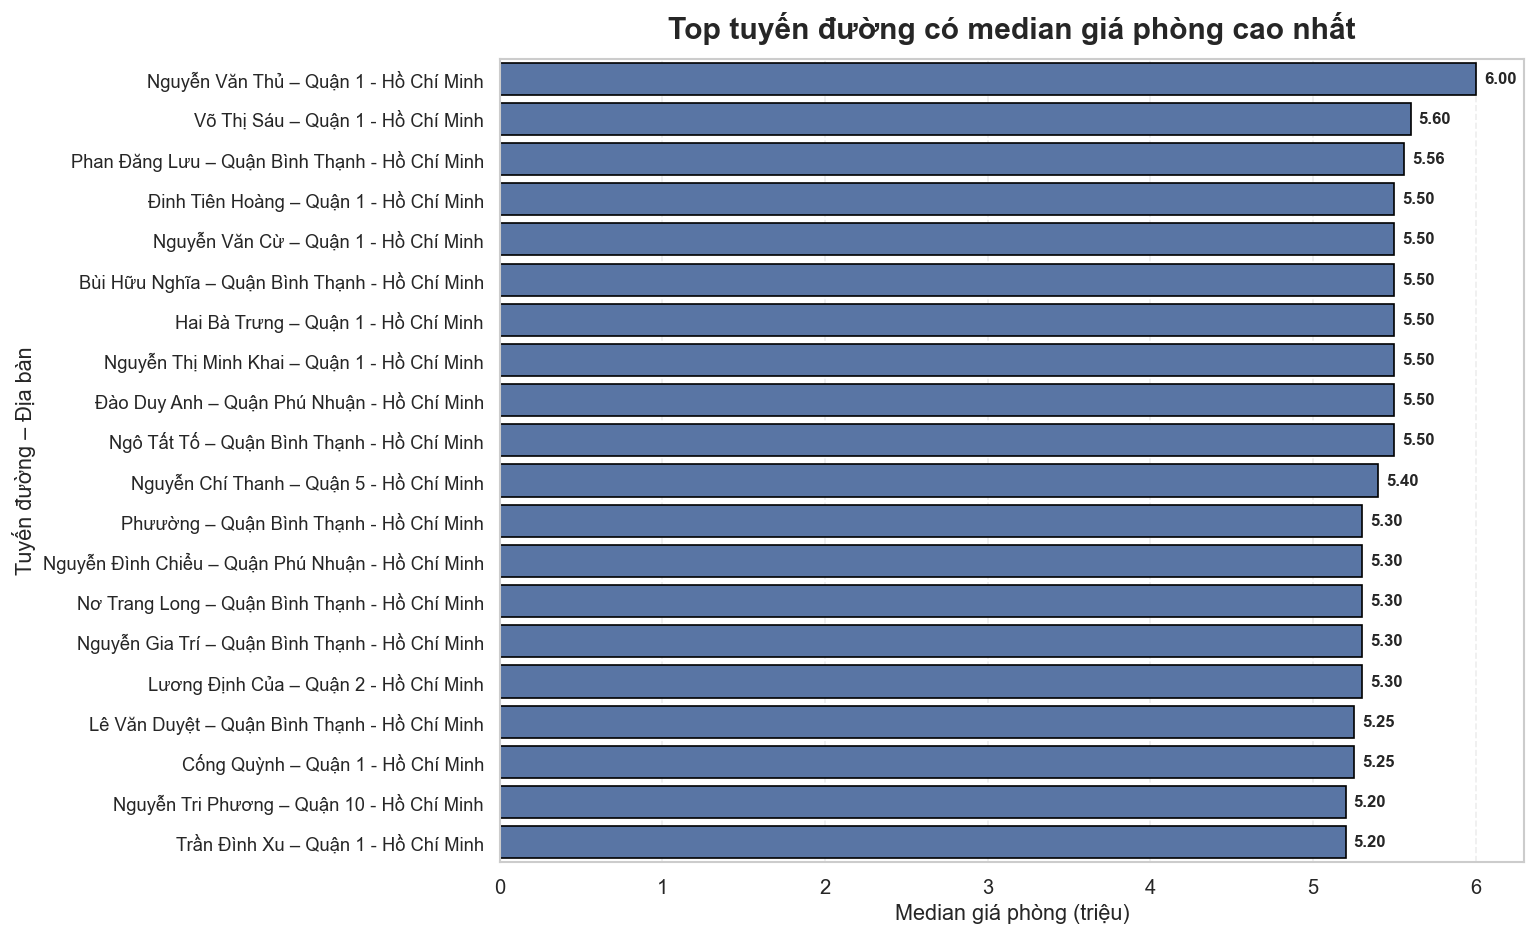

In [14]:
top_n = 20
top_pairs = price_by_address_street.head(top_n).copy()

# Tạo nhãn gộp: "Đường – Quận"
top_pairs["label"] = top_pairs[street_col] + " – " + top_pairs[district_col]

plt.figure(figsize=(13, 8))

ax = sns.barplot(
    data=top_pairs,
    x="median_price",
    y="label",
    color="#4C72B0",
    edgecolor="black"              # thêm viền để dễ nhìn
)

plt.title("Top tuyến đường có median giá phòng cao nhất", fontsize=18, weight="bold", pad=12)
plt.xlabel("Median giá phòng (triệu)", fontsize=13)
plt.ylabel("Tuyến đường – Địa bàn", fontsize=13)

plt.grid(axis="x", linestyle="--", alpha=0.35)

# Tăng spacing giữa các bar
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)

# Hiển thị giá trị (format đẹp) ngay bên phải mỗi bar
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    ax.text(
        width + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.2f}",          # format 1,234,567.89
        va="center",
        ha="left",
        fontsize=10,
        weight="bold"
    )

plt.tight_layout()
plt.show()

### **Phân tích & Nhận xét**

#### **1. Xu hướng chung: Giá phòng cao tập trung ở trung tâm (Quận 1, Bình Thạnh)**
Trong top 20 tuyến đường đắt nhất, phần lớn thuộc:
* Quận 1
* Quận Bình Thạnh

Điều này xác nhận rằng **vị trí địa lý (địa bàn) vẫn là yếu tố quyết định mạnh nhất** đối với giá phòng.
* **Median giá trên các tuyến đắt nhất dao động 5.2 – 6.0 triệu**, cao hơn rõ rệt so với median theo quận (thường chỉ 3–4 triệu).
* Nghĩa là ngay trong 1 quận, mức giá có thể dao động mạnh theo từng tuyến đường.
* Một điểm thú vị khác:
  - Khi xét top địa bàn có nhiều tin đăng nhất, Quận 1 không xuất hiện.
  - Nhưng khi xét top tuyến đường đắt nhất, Quận 1 lại chiếm tỷ trọng lớn.
* Điều này hoàn toàn hợp lý:
  - Quận 1 có diện tích nhỏ nhất TP.HCM, số lượng tin đăng ít hơn quận ven.
  - Tuy nhiên, Quận 1 là nơi tập trung nhiều cơ quan hành chính – văn phòng – thương mại, nên phòng trọ thường tập trung tại một số tuyến đường nhất định và đồng thời cũng khiến những tuyến này có mặt bằng giá cao hơn hẳn.

#### **2. Những tuyến đường “đắt đỏ” nhất & lý do hợp lý theo thực tế**
Dưới đây là những tuyến đường dẫn đầu cùng lý do có thể giải thích theo thực tế khu vực:

**2.1. Nguyễn Văn Thủ (Quận 1) – Median 6.0 triệu**
* Gần trung tâm hành chính – tài chính (Đa Kao).
* Nhiều căn hộ dịch vụ mini, khách thuê chủ yếu dân văn phòng.
* Tiện ích rất cao → AC 94%, Balcony 76%, Elevator 100%.
* **Đặc điểm mạnh:** Diện tích trung bình ~32 m² → lớn hơn mặt bằng chung phòng trọ.

**2.2. Võ Thị Sáu (Quận 1) – Median 5.6 triệu**
* Tuyến đường lớn, thông nhiều Q1–Q3–Phú Nhuận.
* Gần trường học, văn phòng → nhu cầu cao.
* Mức tiện ích rất cao: Balcony 100%, Elevator 100%.

**2.3. Phan Đăng Lưu (Bình Thạnh) – Median 5.56 triệu**
* Cửa ngõ đông đúc, gần Phú Nhuận và Q1.
* Diện tích rộng (34m²).
* Tất cả tiện ích gần như 100%.

**2.4. Bùi Hữu Nghĩa (Bình Thạnh) – Median 5.5 triệu**
* Gần khu D1, cầu Thị Nghè, nối Q1 và Q2.
* Giá hợp lý nhưng tiện ích cực cao:
    * Mezzanine 96%
    * Balcony 100%
    * Elevator 100%

**2.5. Hai Bà Trưng (Quận 1) – Median 5.5 triệu**
* Tuyến đường trung tâm, gần Diamond – Lê Duẩn – Nhà Thờ Đức Bà.
* Lượng phòng cao cấp nhiều (studio mini, dịch vụ tốt).

#### **3. Những tuyến đường “gây bất ngờ”**
**3.1. Nơ Trang Long (Bình Thạnh)**
* **Median: 5.3 triệu**
* Là tuyến đường có nhiều phòng trọ cho thuê nhất (Khi xem google maps ta có thể hiểu được vì đây là một tuyến đường khá dài)
* Mặc dù đường đông xe, nhà cũ nhiều nhưng vẫn có trong top .
* Bộ tiện ích gần như 90–100% ở tất cả cột.

**3.2. Nguyễn Gia Trí (D2) – Bình Thạnh**
* Khu sinh viên, gần ĐH Ngoại Thương nhưng giá vẫn lên đến **5.3 triệu** chứng tỏ phân khúc căn hộ mini cho sinh viên khá mạnh.

#### **4. Diện tích trung bình có vai trò rất lớn trong sự khác biệt giá**
Nhìn các số liệu diện tích:

| Tuyến đường | Mean area (m²) | Median area | Nhận xét |
| :--- | :--- | :--- | :--- |
| Nguyễn Văn Thủ | 32.1 | 30 | Phòng rộng → giá cao |
| Hai Bà Trưng | 34.5 | 32.5 | Không gian “studio cao cấp” |
| Phan Đăng Lưu | 34.5 | 30 | Diện tích lớn nhất nhóm top |
| Nơ Trang Long | 28.7 | 30 | Nhỏ hơn → giá thấp hơn một chút |
| Cống Quỳnh | 32.9 | 30 | Nhiều căn hộ dịch vụ cao cấp |

**Nhận xét:**
Khi 2 tuyến đường cùng quận, tuyến nào có diện tích trung bình lớn hơn → giá cao hơn đáng kể. Gợi ý ta có thể FE thêm `mean_area_by_street`, hoặc `area / street_median_area` trong modeling.

#### **5. Tiện ích cũng góp phần đẩy giá – nhưng theo nhóm**
Hầu hết các tuyến đường top đầu đều có tiện ích rất cao:
* AC: 85–100%
* Washing machine: 80–100%
* Mezzanine: 88–100%
* Balcony: 82–100%
* Elevator: 96–100%

**Nhưng có điều đáng chú ý:**
Không phải tiện ích nào cũng làm giá tăng mạnh.
Giá cao thường đi kèm **combo tiện ích + vị trí + diện tích**, chứ không phải 1 tiện ích riêng lẻ.

*Ví dụ:*
* **Bùi Hữu Nghĩa (Bình Thạnh):** Tiện ích gần như full (90–100%) + Diện tích ~28 m² (nhỏ hơn) → **Giá 5.5 triệu** (cao nhưng không phải cao nhất).
* **Hai Bà Trưng (Quận 1):** Tiện ích tương đương + Diện tích lớn hơn (34 m²) → **Giá tương đương 5.5 triệu** → hợp lý theo logic cung-cầu.

#### **6. Những tuyến đường cùng quận nhưng giá chênh lệch mạnh**
**Quận Bình Thạnh:**

| Street | Median | Area | Nhận xét |
| :--- | :--- | :--- | :--- |
| Phan Đăng Lưu | 5.56 | 34.5 | Gần trung tâm – phòng lớn |
| Bùi Hữu Nghĩa | 5.5 | 28.4 | Tiện ích cao |
| Nguyễn Gia Trí | 5.3 | 31.2 | Khu sinh viên – demand cao |
| Nguyễn Văn Đậu | 5.2 | 28.6 | Phổ thông hơn |

**Nhận xét:** giá lệch theo **khoảng cách tới Q1 + diện tích + nhu cầu khách thuê.**

#### **7. Feature Engineering**
**Nên tạo các feature sau:**
* **street_median_price:** Giá trung vị của từng tuyến đường. Mạnh hơn `address_median_price`.
* **delta_street_vs_district:** Chênh lệch giá của tuyến đường so với quận. Giúp model hiểu “hot street”.
* **mean_area_by_street:** Đánh giá mặt bằng diện tích phòng trên tuyến đường.
* **amenity_density_by_street:** Tiện ích trung bình (0–1) trên tuyến đường → proxy cho “đời phòng”.

#### **8. Kết luận**
* **Địa bàn + tuyến đường + diện tích** là 3 yếu tố chi phối giá mạnh nhất.
* Các tuyến đường đắt nhất đều thuộc quận trung tâm hoặc khu sầm uất (Q1, Bình Thạnh, Phú Nhuận).
* Tiện ích cao là đặc điểm chung nhưng không phải yếu tố quyết định duy nhất.
* Sự kết hợp giữa **phân khúc phòng** (studio vs trọ thường) và **đời phòng** đóng vai trò rất lớn.
* Các feature dựa trên tuyến đường sẽ tăng chất lượng mô hình dự đoán giá rõ rệt.

---

#### **Sự chênh lệch của các tuyến đường so với địa bàn**

In [15]:
df_street_price = price_by_address_street.copy()

# 1) Median mỗi quận
district_median = df_street_price.groupby("address")["median_price"].median()

df_street_price["district_median"] = df_street_price["address"].map(district_median)
df_street_price["delta_vs_district"] = (
    df_street_price["median_price"] - df_street_price["district_median"]
)

# Lấy top tuyến đường đắt hơn quận
top_delta = (
    df_street_price
    .sort_values("delta_vs_district", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

cols_to_show = [
    "address",
    "street_name",
    "count",
    "median_price",
    "district_median",
    "delta_vs_district",
]

if "mean_area" in df_street_price.columns:
    cols_to_show += ["mean_area", "median_area"]

sample_amenities = [
    "amenity_air_conditioning",
    "amenity_balcony",
    "amenity_mezzanine",
    "amenity_elevator",
    "amenity_parking",
]

for col in sample_amenities:
    if col in df_street_price.columns:
        cols_to_show.append(col)

display(top_delta[cols_to_show].round(2))

,address,street_name,count,median_price,district_median,delta_vs_district,mean_area,median_area,amenity_air_conditioning,amenity_balcony,amenity_mezzanine,amenity_elevator,amenity_parking
0,Quận Tân Bình - Hồ Chí Minh,Yên Thế,18,5.15,4.00,1.15,29.67,30.0,1.00,1.00,0.89,0.94,0.89
1,Quận Ba Đình - Hà Nội,Đội Cấn,16,4.90,3.80,1.10,28.44,26.0,0.94,0.88,0.88,1.00,0.81
2,Quận Thanh Xuân - Hà Nội,Triều Khúc,12,3.85,2.78,1.08,28.25,25.5,0.92,1.00,1.00,1.00,0.83
3,Quận 9 - Hồ Chí Minh,Tây Hòa,16,4.50,3.42,1.08,37.69,29.5,0.88,1.00,0.94,1.00,0.88
4,Quận Tân Bình - Hồ Chí Minh,Ni Sư Huỳnh Liên,18,5.00,4.00,1.00,28.06,30.0,1.00,1.00,1.00,1.00,0.83
5,Quận 5 - Hồ Chí Minh,Nguyễn Chí Thanh,13,5.40,4.40,1.00,30.00,25.0,1.00,0.92,1.00,1.00,1.00
6,Quận 2 - Hồ Chí Minh,Lương Định Của,11,5.30,4.30,1.00,24.09,26.0,0.91,1.00,0.91,1.00,0.91
7,Quận Bình Tân - Hồ Chí Minh,Số 4,10,3.70,2.80,0.90,52.40,22.0,1.00,0.80,1.00,1.00,0.60
8,Quận 12 - Hồ Chí Minh,Hà Thị Khiêm,18,3.90,3.00,0.90,25.94,25.0,1.00,0.89,0.94,1.00,0.94
9,Quận 4 - Hồ Chí Minh,Tôn Thất Thuyết,36,4.25,3.40,0.85,24.75,25.0,0.92,0.75,0.94,0.94,0.92


#### **Visualize**

C:\Users\Phuc Chau\AppData\Local\Temp\ipykernel_11512\3298707350.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)


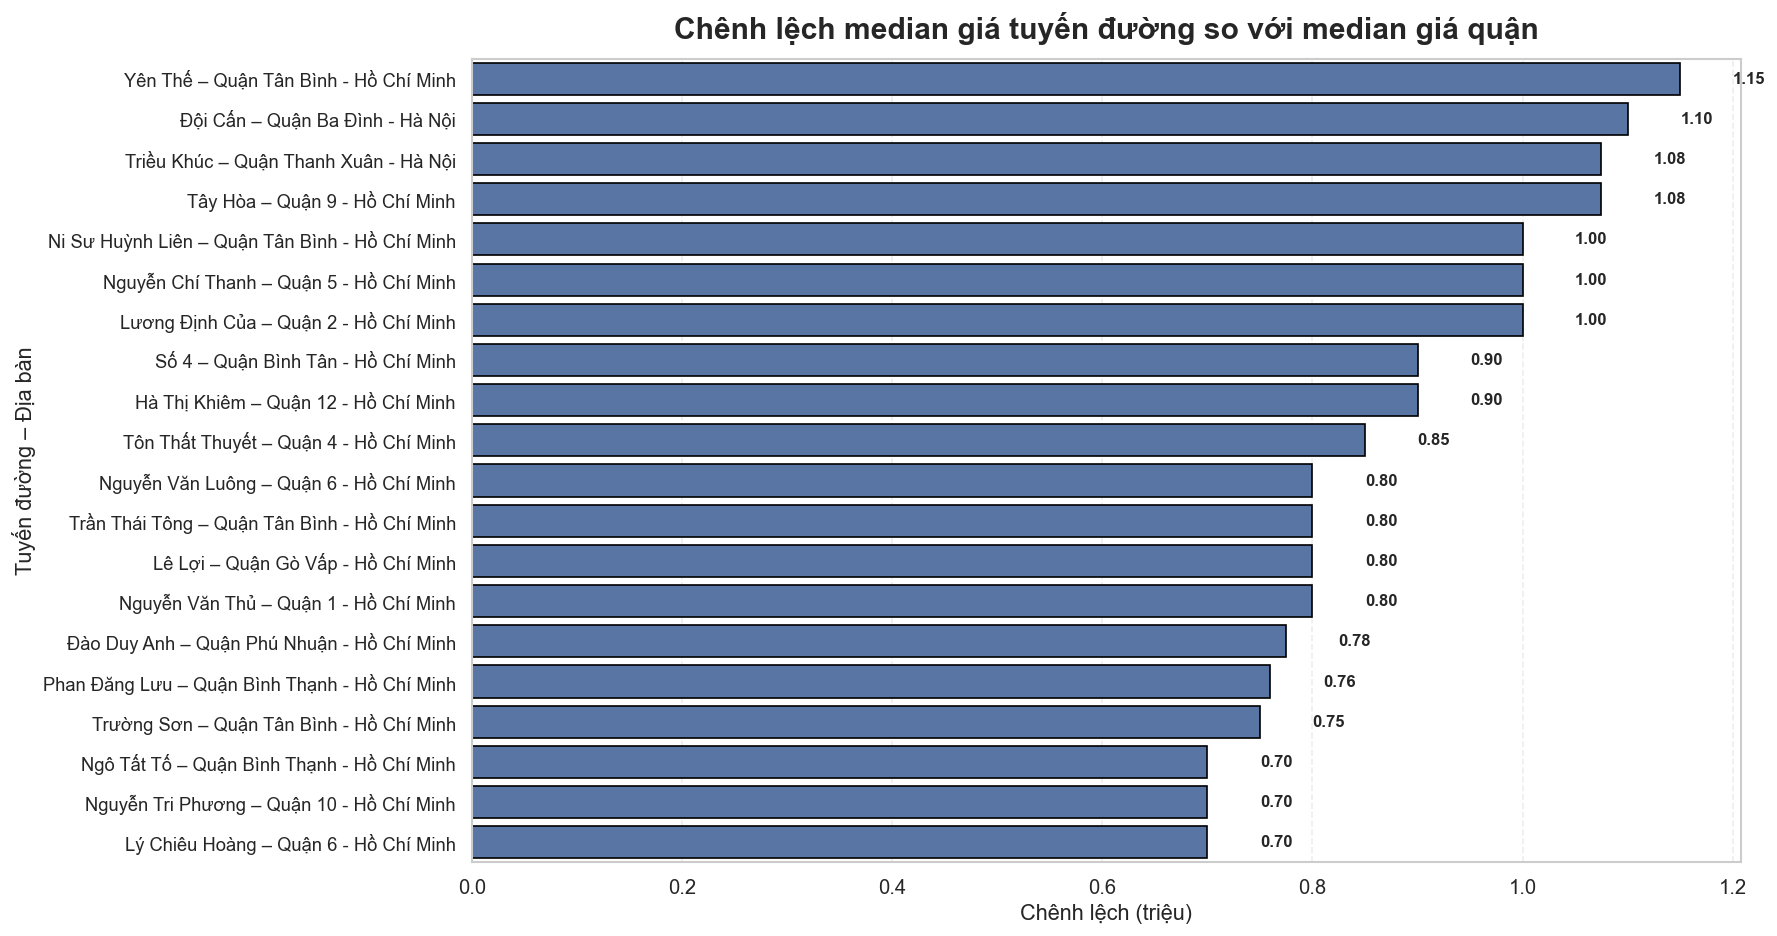

In [16]:
# Tạo label gộp: "street_name – address"
top_delta["label"] = top_delta["street_name"] + " – " + top_delta["address"]

plt.figure(figsize=(15, 8))
ax = sns.barplot(
    data=top_delta,
    x="delta_vs_district",
    y="label",
    color="#4C72B0",
    edgecolor="black"
)

plt.title("Chênh lệch median giá tuyến đường so với median giá quận", 
          fontsize=18, weight="bold", pad=12)

plt.xlabel("Chênh lệch (triệu)", fontsize=13)
plt.ylabel("Tuyến đường – Địa bàn", fontsize=13)

plt.grid(axis='x', linestyle="--", alpha=0.35)

# Ghi số lên thanh (format đẹp)
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    ax.text(
        width + 0.05,
        bar.get_y() + bar.get_height()/2,
        f"{width:,.2f}",   # format có dấu phẩy
        ha="left",
        va="center",
        fontsize=10,
        weight="bold"
    )

ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)

plt.tight_layout()
plt.show()

### **Phân tích & Nhận xét**

Bảng kết quả cho thấy **sự khác biệt rất lớn giữa giá phòng theo từng tuyến đường**, ngay cả khi nằm trong cùng một quận. Điều này nhấn mạnh rằng: **Địa chỉ (street-level location)** quan trọng không kém, thậm chí quan trọng **hơn cả quận**, khi đánh giá giá phòng trọ.

#### **1. Tuyến đường tăng giá mạnh nhất đều nằm ở quận có nhu cầu rất cao**

Những tuyến dẫn đầu chênh lệch:

| Tuyến đường | Quận | Delta |
|-------------|------|--------|
| **Yên Thế** | Tân Bình | **+1.15 triệu**  
| **Đội Cấn** | Ba Đình (HN) | **+1.10 triệu**  
| **Triều Khúc** | Thanh Xuân (HN) | **+1.08 triệu**  
| **Tây Hòa** | Quận 9 | **+1.08 triệu**  

**Giải thích:**
- Đây đều là **trục giao thông lớn**, đông dân cư, nhu cầu thuê cực cao.  
- Nhiều phòng **đời mới**, có nhiều tiện ích, phù hợp người đi làm / sinh viên.  
- Nhu cầu thuê cao dẫn đến giá bị đẩy lên cao.

**Ví dụ điển hình: Yên Thế – Quận Tân Bình**
- Gần sân bay Tân Sơn Nhất, các trường đại học Công Nghiệp và có công viên Gia Định khá lớn .  
- Người thuê ngắn hạn và dài hạn đều đông  
- Tiện ích gần như full: Ban công, thang máy, máy lạnh  
-> Không ngạc nhiên khi Yên Thế đứng đầu danh sách.

#### **2. Tuyến đường “đắt bất thường” so với mặt bằng quận**

Một số tuyến tuy **không thuộc quận đắt đỏ**, nhưng lại có chênh lệch cao:

**Lương Định Của – Quận 2 (+1.00 triệu)**
- Gần khu vực Thủ Thiêm – được quy hoạch thành "trung tâm mới của Sài Gòn"  
- Nhiều studio đẹp  
- Gần trung tâm  
→ Giá “vượt” mặt bằng quận

**Số 4 – Bình Tân (+0.90 triệu)**
- Bình Tân vốn rẻ nhưng phòng tại tuyến này:  
  - **Diện tích 52m²** (rất lớn)  
  - Tiện ích full  
  - Khu vực quy hoạch bài bản
→ Giá cao do **diện tích + chất lượng phòng**, không phải do vị trí.

#### **3. Diện tích cũng là một yếu tố đẩy giá**

Một số tuyến có diện tích trung bình lớn trong top:
- Số 4 (Bình Tân): **52.4 m²**  
- Lê Lợi (Gò Vấp): **39.8 m²**  
- Tây Hòa (Quận 9): **37.7 m²**

Trong khi các tuyến Quận 1 chỉ ~30 m².

→ **Diện tích cũng là một feature quan trọng khi xét chênh lệch giá giữa các tuyến đường.**

#### **4. Hà Nội xuất hiện khi xét “độ lệch giá”, dù không xuất hiện trong top địa bàn hoặc top tuyến đường**
Một điểm rất thú vị là:
- **Ở danh sách top địa bàn xuất hiện nhiều tin nhất → không có quận nào của Hà Nội hay địa phương khác.**  
- **Ở danh sách top tuyến đường xét theo giá median → cũng không có tên tuyến đường Hà Nội.**

Nhưng khi chuyển sang phân tích *chênh lệch giá tuyến đường so với mặt bằng quận*, **Hà Nội bất ngờ xuất hiện với 2 ứng viên:**
- **Đội Cấn – Quận Ba Đình** (+1.10 triệu)  
- **Triều Khúc – Quận Thanh Xuân** (+1.08 triệu)

Điều này cho thấy:

- Dù không phải nơi có nhiều tin đăng như TP.HCM,  
- Và cũng không phải nơi có các tuyến đường có median giá tuyệt đối cao nhất,  
- **Nhưng một số tuyến đường tại Hà Nội lại đắt “bất thường” so với chính quận của chúng.**

**Giải thích theo thực tế:**

- **Ba Đình và Thanh Xuân đều là khu trung tâm – lõi hành chính, kinh tế, giáo dục của Hà Nội**, nên mức giá phòng tăng mạnh ở các tuyến đường tập trung sinh viên, người đi làm, hoặc gần các tiện ích trọng điểm.
- Điều này phản ánh rằng **sự phân hóa giá trong nội bộ từng quận ở Hà Nội khá lớn**, đặc biệt ở các tuyến đường đông sinh viên (Triều Khúc) hoặc gần trung tâm hành chính (Đội Cấn).

#### **Kết luận**

| Yếu tố | Tác động |
|--------|----------|
| Địa bàn quận | ảnh hưởng giá tổng thể  
| Tuyến đường | quyết định giá cao hay thấp  
| Tiện ích đầy đủ | giúp tăng giá nhẹ nhưng giữ “chuẩn cao cấp”  
| Diện tích | tác động cao đến giá  
| Quận 2, Tân Bình, Bình Thạnh | nhiều tuyến đường “đắt vượt quận”  
| Quận ven (9, 12, Gò Vấp) | giá tăng mạnh nếu tuyến đường tập trung phòng đời mới  


Từ các nhận định trên ta có thể tạo các feature rất mạnh như:
- `street_median_price`  
- `delta_price_vs_district`  
- `is_hot_street` (1/0)  
- `amenity_score`  
- `area_bucket`  

Những feature này sẽ giúp mô hình **nhận diện phân khúc giá chính xác hơn rất nhiều**.

---

### **3.2.3. Giá phòng theo tiện ích**
Mặc dù ở phần tương quan ta đã thấy rằng tiện ích không có mối liên hệ tuyến tính mạnh với giá phòng, nhưng điều đó không đồng nghĩa với việc tiện ích không ảnh hưởng đến mức giá. **Tương quan chỉ đo mức độ tuyến tính, trong khi tác động của tiện ích thường mang tính phân khúc (categorical effect), không phải tuyến tính.**

Vì vậy, trong phần này ta tiếp tục kiểm tra xem: **Liệu các tiện ích có tạo ra sự khác biệt đáng kể về giá hay không?**

#### Cách làm:
1. **Chọn một số tiện ích quan trọng, dễ ảnh hưởng đến giá:**
   * mezzanine – gác lửng
   * balcony – ban công
   * elevator – thang máy
   * parking – chỗ để xe
   * air_conditioning – máy lạnh
   * kitchen – bếp

2. **Với từng tiện ích, tiến hành:**
   * Chia phòng thành nhóm **có (1/True)** và nhóm **không (0/False)**
   * **Tính thống kê:**
     * count, mean, median, q25, q75, min, max
   * **So sánh:**
     * Nhóm có tiện ích cao hơn bao nhiêu % so với nhóm không có
     * Mức độ chênh lệch median để xem tiện ích đó thực sự ảnh hưởng đến giá hay không

#### Ý nghĩa phân tích
Phân tích này giúp xác định:
* **Tiện ích nào thực sự làm tăng giá** → nên giữ lại khi xây dựng mô hình
* **Tiện ích nào chỉ mang tính cơ bản** → ít ảnh hưởng, có thể bỏ nếu cần giảm số lượng feature
* **Những tiện ích “tín hiệu mạnh”** giúp model dễ phân biệt phân khúc phòng (studio – gác – cao cấp)

In [17]:
amenities_for_price = [
    "air_conditioning",
    "fridge",
    "washing_machine",
    "mezzanine",
    "kitchen",
    "wardrobe",
    "bed",
    "balcony",
    "elevator",
    "free_time",
    "parking",
]

amenities_for_price = [c for c in amenities_for_price if c in df_price.columns]

def q25(x): 
    return x.quantile(0.25)

def q75(x): 
    return x.quantile(0.75)

def price_stats_by_amenity(df_src, amenity_col, price_col="price"):
    s = df_src[amenity_col]
    if s.dtype == bool:
        s = s.astype(int)

    mask_valid = s.isin([0, 1])
    df_valid = df_src[mask_valid].copy()
    df_valid[amenity_col] = s[mask_valid]

    if df_valid.empty:
        return None

    stats = (
        df_valid
        .groupby(amenity_col)[price_col]
        .agg(
            count="size",
            mean="mean",
            median="median",
            q25=q25,
            q75=q75,
            min="min",
            max="max",
        )
    )
    return stats


rows = []

for col in amenities_for_price:
    stats = price_stats_by_amenity(df_price, col, price_col)
    if stats is None:
        continue

    if not set(stats.index) >= {0, 1}:
        continue

    median_no = stats.loc[0, "median"]
    median_yes = stats.loc[1, "median"]

    if median_no > 0:
        diff_abs = median_yes - median_no
        diff_pct = diff_abs / median_no * 100
    else:
        diff_abs = float("nan")
        diff_pct = float("nan")

    rows.append(
        {
            "amenity":   col,
            "count_no":  stats.loc[0, "count"],
            "count_yes": stats.loc[1, "count"],
            "median_no": median_no,
            "median_yes": median_yes,
            "diff_abs":  diff_abs,
            "diff_pct":  diff_pct,
        }
    )


if rows:
    summary_amenity_effect = (
        pd.DataFrame(rows)
        .sort_values("diff_pct", ascending=False)
        .reset_index(drop=True)
    )

    print("Ảnh hưởng của từng tiện ích đến median giá phòng:")

    df_show = summary_amenity_effect.copy()

    df_show["Tiện ích"] = (
        df_show["amenity"]
        .str.replace("_", " ")
        .str.title()
    )

    df_show = df_show.rename(columns={
        "count_no":   "Số lượng (không có)",
        "count_yes":  "Số lượng (có)",
        "median_no":  "Median (không)",
        "median_yes": "Median (có)",
        "diff_abs":   "Chênh lệch",
        "diff_pct":   "Chênh lệch (%)",
    })

    df_show = df_show[
        [
            "Tiện ích",
            "Số lượng (không có)",
            "Số lượng (có)",
            "Median (không)",
            "Median (có)",
            "Chênh lệch",
            "Chênh lệch (%)",
        ]
    ]

    num_cols = [
        "Số lượng (không có)",
        "Số lượng (có)",
        "Median (không)",
        "Median (có)",
        "Chênh lệch",
        "Chênh lệch (%)",
    ]

    df_show[num_cols] = df_show[num_cols].round(2)

    display(df_show)

else:
    print("Không có tiện ích nào có đủ 2 nhóm 0/1 để so sánh median.")


Ảnh hưởng của từng tiện ích đến median giá phòng:


,Tiện ích,Số lượng (không có),Số lượng (có),Median (không),Median (có),Chênh lệch,Chênh lệch (%)
0,Balcony,2810,21252,3.8,3.8,0.0,0.00
1,Free Time,3254,20808,3.8,3.8,0.0,0.00
2,Kitchen,3778,20284,3.8,3.7,-0.1,-2.63
3,Parking,3568,20494,3.9,3.7,-0.2,-5.13
4,Air Conditioning,1920,22142,4.0,3.7,-0.3,-7.50
5,Fridge,4479,19583,4.0,3.7,-0.3,-7.50
6,Washing Machine,2452,21610,4.0,3.7,-0.3,-7.50
7,Mezzanine,1508,22554,4.0,3.7,-0.3,-7.50
8,Wardrobe,5737,18325,4.0,3.7,-0.3,-7.50
9,Bed,4902,19160,4.0,3.7,-0.3,-7.50


#### **Visualize**

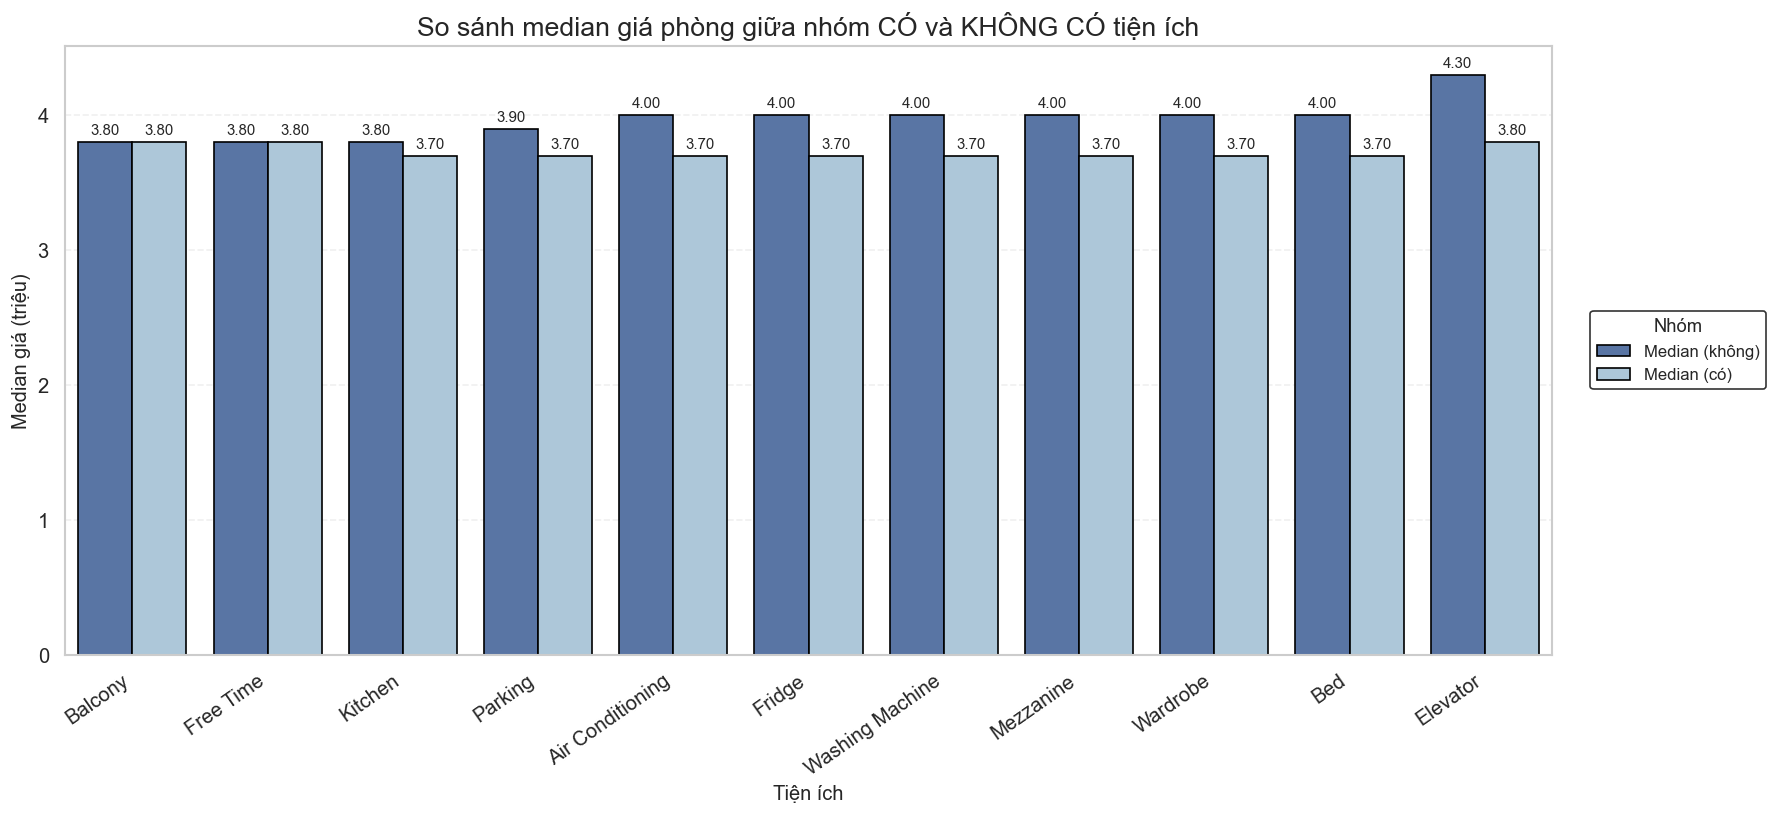

In [18]:
df_plot = df_show.copy()
df_plot = df_plot[["Tiện ích", "Median (không)", "Median (có)"]]

df_melt = df_plot.melt(
    id_vars="Tiện ích",
    value_vars=["Median (không)", "Median (có)"],
    var_name="Nhóm",
    value_name="Median Giá"
)

colors = ["#4C72B0", "#A6C8E0"]

plt.figure(figsize=(15, 7))
ax = sns.barplot(
    data=df_melt,
    x="Tiện ích",
    y="Median Giá",
    hue="Nhóm",
    palette=colors,
    edgecolor="black"
)

plt.title("So sánh median giá phòng giữa nhóm CÓ và KHÔNG CÓ tiện ích", fontsize=16)
plt.xlabel("Tiện ích", fontsize=12)
plt.ylabel("Median giá (triệu)", fontsize=12)
plt.xticks(rotation=35, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)

for bar in ax.patches:
    h = bar.get_height()
    if h > 0.3:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.03,
            f"{h:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.legend(
    title="Nhóm",
    fontsize=10,
    title_fontsize=11,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

plt.tight_layout()
plt.show()

#### **Phân tích & Nhận xét**

Kết quả cho thấy tất cả các tiện ích đều có chênh lệch giá nhỏ, đặt biệt nhiều tiện ích khiến median giá giảm thay vì tăng. Điều này dẫn đến một số kết luận quan trọng:

##### **1. Các tiện ích không làm giá phòng tăng lên thậm chí còn giảm**
Nhìn vào cột Chênh lệch (%), ta thấy:

| Tiện ích | Chênh lệch (%) |
| :--- | :--- |
| Balcony | 0.0% |
| Free Time | 0.0% |
| Kitchen | –2.63% |
| Parking | –5.13% |
| Air Conditioning | –7.5% |
| Fridge | –7.5% |
| Washing Machine | –7.5% |
| Mezzanine | –7.5% |
| Wardrobe | –7.5% |
| Bed | –7.5% |
| Elevator | –11.63% |

Không có tiện ích nào làm tăng median. Thậm chí **elevator (thang máy)** có mức chênh lệch âm mạnh nhất (–11.63%).

**Giải thích thực tế:**
- Các tiện ích này quá phổ biến, tỉ lệ sở hữu cao đến mức: “Có tiện ích” là tiêu chuẩn tối thiểu thời nay, không phải điểm cộng để tăng giá.
Mặc dù trực giác thường khiến ta nghĩ rằng **“có thêm tiện ích thì giá phải cao hơn”**, nhưng thực tế dữ liệu lại cho thấy điều ngược lại: **Nhiều tiện ích làm median giá giảm.** Lý do nằm ở cấu trúc phân bố địa lý của các loại phòng:
  * **Những phòng có nhiều tiện ích hiện đại** (gác lửng, thang máy, máy lạnh, máy giặt…) thường tập trung ở khu vực **vùng ven** — nơi quỹ đất rộng, tòa nhà mới, và các chủ trọ cạnh tranh bằng tiện ích để bù lại vị trí xa trung tâm.
  * **Ngược lại:** Những phòng **“không tiện ích”** (không thang máy, không parking, không bếp…) lại xuất hiện chủ yếu tại các khu vực **trung tâm** như Quận 1, Quận 3, Phú Nhuận — nơi vị trí đắt đỏ đến mức không cần đầu tư tiện ích mà giá vẫn cao.

 * **Kết hợp với các phân tích trước:**
    * Tiện ích có tương quan gần bằng 0 với giá, không phải yếu tố quyết định.
    * Giá phòng theo quận và theo tuyến đường cho thấy **vị trí là yếu tố chi phối mạnh nhất**.
    * Các quận trung tâm vốn có mức giá cơ bản cao hơn từ 20–50% so với vùng ven.

Vì vậy, khi so sánh median giữa nhóm có tiện ích và không tiện ích, ta đang vô tình so sánh:
1.  **Phòng vùng ven hiện đại** (nhiều tiện ích nhưng giá thấp hơn)
2.  **Phòng trung tâm nhỏ nhưng đắt** (ít tiện ích nhưng giá cao hơn nhờ vị trí)

**Nên việc median giảm ở nhóm “có tiện ích” là hiện tượng hoàn toàn hợp lý và phản ánh đúng thị trường.** Khi 80–95% phòng đều có tiện ích đó, nó không còn phân biệt phân khúc nữa, vì phòng không có tiện ích mới là “dị”.

##### **2. “Ban công” và “Free Time” có chênh lệch = 0**
* **Balcony:** 0.0%
* **Free Time:** 0.0%

**Ban công không tạo ra sự khác biệt về giá** vì đây không phải là một tiện ích “quyết định hành vi thuê”.
  * Người thuê nhà trọ thường ưu tiên các yếu tố như **diện tích – bếp – máy lạnh – vị trí – chỗ để xe** hơn là ban công.
  * Ban công chỉ làm phòng dễ chịu hơn, thoáng hơn, nhưng không phải là yếu tố khiến người thuê sẵn sàng trả thêm tiền.
 Do đó, việc có hay không ban công ít ảnh hưởng đến mức giá median.

**Free time (giờ giấc tự do)** cũng không tạo ra chênh lệch giá vì bản thân tiện ích này có ưu – nhược điểm cân bằng:
  * **Nếu ở chung chủ** (không free time) thì thông thường được an ninh tốt, trông coi kỹ, phù hợp với nhiều các người thuê có giờ giấc ổn định.
  * **Nếu tự do giờ giấc** thì thoải mái hơn nhưng đi kèm tự quản lý an ninh, môi trường “tự do hơn”, đôi khi kém ổn định hơn.

**Nhận xét:**
* Hai tiện ích này không hề giúp mô hình dự đoán giá.
* Hoặc chỉ nên dùng như feature binary tiêu chuẩn, không kỳ vọng nhiều thông tin.

##### **3. Đúc kết cho Feature Engineering (FE)**
* **Không nên kỳ vọng tiện ích giúp mô hình dự đoán giá tốt.** Nhìn vào thực tế ta có thể thấy tác động thực sự là nhỏ hoặc ngược nghĩa.

* **Tác động giá chủ yếu nằm ở:**
  * Vị trí quận
  * Tên đường
  * Diện tích
  * Đặc điểm mô tả (nội thất cao cấp, view đẹp, gần trung tâm, mới xây)

* **Nên kết hợp tiện ích theo dạng feature tổng hợp:**
  * `amenity_score` = tổng tiện ích
  * `is_premium_unit` = (elevator & balcony & kitchen)
  * `old_vs_new` = 1 nếu có washing_machine + elevator + free_time (phòng mới xây)

##### **Kết luận**
* Tiện ích không phải yếu tố quyết định giá. **Vị trí + diện tích mới là chủ đạo.**

* Tiện ích chủ yếu đại diện **loại hình phòng trò(truyền thống - hiện đại)**, không còn là tiêu chí để định hinh giá trị phòng.
Nhìn vào bảng số liệu, ta thấy giá phòng ở TP.HCM hiện đại hóa ở mức cao đến nỗi tiện ích không còn là điểm phân biệt mạnh, mà chỉ đóng vai trò mô tả “phòng hiện đại” hay “phòng truyền thống” thậm chí nếu không có còn được coi là "kì lạ".

---

## **Initial Observations & Insights**

### **1. Thị trường cho thuê tập trung gần như hoàn toàn ở TP.HCM**
* **Top 10 địa bàn có nhiều tin nhất** đều là quận thuộc TP.HCM: Bình Thạnh, Tân Bình, Gò Vấp, Tân Phú, Quận 7, Quận 12, Quận 10, Bình Tân, Quận 9, Phú Nhuận.
* Các huyện/thị xã ở tỉnh khác (Hậu Giang, Hà Giang, Bạc Liêu, Quảng Trị,…) chỉ có 1 tin, mang tính “điểm xuyết”.
* **Ý nghĩa:**
    * Dataset thực chất đang phản ánh thị trường thuê trọ TP.HCM là chính, các tỉnh/thành khác chỉ đóng vai trò “rìa dữ liệu”.
    * Mọi kết luận về giá, tiện ích, phân khúc… chỉ nên diễn giải cho bối cảnh đô thị lớn (đặc biệt là TP.HCM), không nên khái quát cho cả nước.
    * Trong modeling, nếu đưa cả các tỉnh khác vào mà không xử lý, mô hình sẽ ngầm thiên lệch về TP.HCM (class imbalance theo vùng). Khả năng rất cao ta sẽ chuyển về bài toán dự đoán giá thuê ở khu vực Thành phố Hồ Chí Minh.

### **2. Giá phòng không phụ thuộc tuyến tính vào diện tích hay tiện ích**
* **Kết quả từ ma trận tương quan:**
    * `price ↔ amenities`: khoảng –0.04 → 0.05 → gần như không liên quan tuyến tính.
    * `area ↔ amenities` ≈ 0.
    * `price ↔ area` ≈ 0.085 (rất yếu).
* **Kết luận:**
    * Thêm 1–2 tiện ích như `air_conditioning`, `washing_machine`, `kitchen`, `balcony` không làm giá tăng theo kiểu tuyến tính.
    * Diện tích cũng không phải yếu tố quyết định chính: một phòng 18–20m² ở Quận 1 cũng có thể đắt hơn căn 30–40m² ở quận ven.
* **Điều này hoàn toàn khớp với thực tế:**
    * Ở Sài Gòn, “vị trí” và “phân khúc tòa nhà” thường quyết định giá, chứ không phải mỗi 1m² thêm vào hay thêm 1 cái tủ lạnh.
* **Khi modeling:**
    * Không nên kỳ vọng mô hình tuyến tính đơn giản (Linear, ElasticNet…) với feature chính là `area` + `amenities` sẽ dự đoán giá tốt.
    * Cần: Feature về location (quận, đường, cụm khu vực), Feature phân khúc (full nội thất, căn hộ mini, trọ truyền thống), và mô hình phi tuyến (tree-based, boosted trees,…).

### **3. Tiện ích không định giá trực tiếp, nhưng thể hiện “phân khúc phòng”**
#### 3.1. Các cluster tiện ích rất rõ ràng
Từ các hệ số tương quan giữa tiện ích:
* **Cụm full nội thất:**
    * `fridge ↔ wardrobe`: ~0.81
    * `bed ↔ wardrobe`: ~0.72
    * `bed ↔ fridge`: ~0.63
    * `washing_machine ↔ fridge`: ~0.58
    * `air_conditioning ↔ bed`: ~0.55
    * → Khi chủ trọ đã trang bị thì thường chơi “combo” chứ không trang bị lẻ tẻ.
* **Cụm căn hộ / chung cư mini:**
    * `balcony ↔ bed/wardrobe/fridge`: khoảng 0.35–0.40
    * `elevator ↔ mezzanine/washing_machine`: khoảng 0.24–0.37
    * → Ban công + thang máy + máy giặt thường đi kèm với dạng căn hộ mini / chung cư nhiều tầng.
* `free_time` (giờ giấc tự do) cũng tương quan nhẹ với `washing_machine`, `parking`, `fridge`, `kitchen` → phòng tự do giờ giấc có xu hướng nằm trong tòa nhà tiện nghi hơn.
* **Ý nghĩa:**
    * Tiện ích không “tăng giá 200k – 300k” theo kiểu cộng dồn, mà: Định nghĩa phân khúc: trọ bình dân, full nội thất, căn hộ dịch vụ.
    * Phù hợp dùng để gán nhãn phân khúc hoặc làm feature cho clustering / segmentation.

### **4. “Vị trí” là yếu tố chi phối mạnh nhất: từ quận → đường → chênh lệch so với quận**
#### 4.1. Theo quận (address)
* Nhóm trung tâm / cận trung tâm (Bình Thạnh, Phú Nhuận, Quận 7, Quận 10) có median price từ 4–5 triệu.
* Nhóm ven (Gò Vấp, Tân Phú, Quận 9, Quận 12, Bình Tân) có median ≈ 3 triệu, giá mềm hơn nhưng tiện ích lại rất tốt.
* **Đặc biệt:**
    * **Bình Thạnh:** Median ≈ 5 triệu – cao nhất nhóm. `q25–q75` ~ 4–6 triệu → mặt bằng giá ổn định nhưng vẫn có outlier cao (studio, căn hộ mini gần trung tâm).
    * **Bình Tân:** Median mềm, nhưng max lên tới 260 triệu → outlier rõ ràng.

#### 4.2. Theo tuyến đường (street)
* Khi đi sâu xuống `street_name`: Top 20 tuyến có median giá cao nhất phần lớn nằm ở:
    * Quận 1 (Nguyễn Văn Thủ, Hai Bà Trưng, Cống Quỳnh, Nguyễn Thị Minh Khai, Võ Thị Sáu,…)
    * Bình Thạnh (Phan Đăng Lưu, Bùi Hữu Nghĩa, Ngô Tất Tố, Nơ Trang Long, Nguyễn Gia Trí,…)
* Median đường ~5.2–6.0 triệu, cao hơn rõ rệt so với median quận (thường chỉ 3–4 triệu).
* **Một điều đặc biệt:** Quận 1 không xuất hiện trong top quận nhiều tin, nhưng khi xét tuyến đường đắt nhất thì Quận 1 lại chiếm tỷ trọng lớn → do diện tích quận nhỏ, phòng trọ tập trung vào vài tuyến “đinh”, nhưng những tuyến này lại cực kỳ đắt.

#### 4.3. Delta vs district – khi “sốc giá” xuất hiện
* Khi so sánh median_price của tuyến đường với district_median: Các tuyến như Yên Thế, Ni Sư Huỳnh Liên (Tân Bình), Lương Định Của (Quận 2), Tây Hòa (Quận 9), Nguyễn Văn Thủ (Q1)… có `delta_vs_district` từ +0.7 đến +1.15 triệu.
* **Đặc biệt thú vị:** Khi xét top địa bàn và top street theo giá tuyệt đối → không thấy HN xuất hiện. Nhưng khi xét chênh lệch tuyến đường so với quận, xuất hiện 2 cái tên từ Hà Nội:
    * Đội Cấn – Ba Đình
    * Triều Khúc – Thanh Xuân
    * → Đây là những tuyến đắt “bất thường” so với chính quận của nó.
* **Ý nghĩa:**
    * Đường phố (street-level) chứa rất nhiều thông tin về “độ hot” của khu vực.
    * `delta_price_vs_district` là một feature cực mạnh để nhận diện “hot street” và điều chỉnh giá so với mặt bằng chung.

### **5. Tiện ích gần như không làm giá tăng – thậm chí nhóm “có tiện ích” còn rẻ hơn**
* **Khi so sánh median giá có / không tiện ích:** Không tiện ích nào làm median tăng lên, nhiều cái còn làm median giảm 5–10%:
    * `Elevator`: –11.6%
    * `Air_conditioning`, `fridge`, `washing_machine`, `mezzanine`, `wardrobe`, `bed`: khoảng –7.5%
    * `Kitchen`, `parking`: chênh lệch âm nhẹ
    * `Balcony`, `free_time`: ~0%
* **Như đã giải thích bên trên:**
    * **Phòng có nhiều tiện ích:** Tập trung ở quận ven (Quận 9, 12, Gò Vấp, Tân Phú,…). Được xây mới, có thang máy, máy giặt, full nội thất để bù cho vị trí xa trung tâm cho nên giá vẫn "mềm".
    * **Phòng không nhiều tiện ích:** Tập trung nhiều hơn ở quận trung tâm (Q1, Q3, Phú Nhuận, Bình Thạnh). Dù thiếu tiện ích nhưng vị trí quá ngon nên giá vẫn cao.
* **Do đó:** Khi nhìn thuần tuý theo tiện ích, ta thấy “có tiện ích” lại rẻ hơn “không tiện ích” là chuyện hoàn toàn hợp lý. Tiện ích không phải là công cụ chính của giá, mà bị “vị trí đè giá”.
* **Ý nghĩa cho FE & modeling:** Tiện ích không phù hợp để dùng như “feature định giá trực tiếp”. Nhưng lại rất phù hợp để phân khúc loại phòng (bình dân / full nội thất / căn hộ mini) hoặc ước lượng “đời phòng” (phòng mới hay cũ, nhà xây mới hay nhà lâu năm).

### **Kết luận**
Từ toàn bộ các phân tích trên, có thể tóm tắt:
1.  **Location is king:** Từ quận → đường → “độ lệch so với quận”, tất cả đều cho thấy vị trí là nhân tố chi phối mạnh nhất đến giá. HCM là “trọng tâm dữ liệu”, các tỉnh khác chỉ là phụ.
2.  **Tiện ích phản ánh phân khúc, không định giá tuyến tính:** Full nội thất & căn hộ mini tạo thành các cluster rất rõ trong ma trận tương quan. Nhưng ảnh hưởng đến giá bị lấn át bởi vị trí.
3.  **Quận ven (tiện ích tốt, giá mềm) vs Quận trung tâm (tiện ích ít hơn, giá cao):** Giải thích vì sao median nhóm “có tiện ích” lại thấp hơn nhóm “không tiện ích”.
4.  **Tuyến đường là đơn vị phân giải rất tốt:** Cùng quận nhưng tuyến đường chênh nhau 0.5–1.5 triệu là chuyện bình thường. `street_median_price` và `delta_vs_district` là hai feature cực kỳ tiềm năng.
5.  **Feature Engineering nên xoay quanh:**
    * `district_median_price`, `street_median_price`, `delta_price_vs_district`
    * `amenity_score`, `is_full_furnished`, `is_apartment_like`
    * `area_bucket`, `center_vs_suburb`

---

## **Red Flags**

### 1. Data imbalance rất lớn giữa TP.HCM và các tỉnh khác
* TP.HCM chiếm gần như toàn bộ tin đăng. Nhiều huyện/tỉnh chỉ có 1–2 dòng → thống kê theo các địa bàn này không đáng tin.
* **Hệ quả:** Mô hình học ra sẽ thiên về hành vi thị trường ở TP.HCM. Nếu deploy cho tỉnh/thành khác → kết quả dự đoán có thể sai lệch lớn.

### 2. Nhiều quận/huyện & tuyến đường có số mẫu rất nhỏ
* Một số quận/tỉnh chỉ có vài tin → median, mean, q25, q75… rất dễ nhiễu.
* Một số tuyến đường trong phân tích giá theo street phải lọc bằng ngưỡng `min_ads_street`, `min_ads_pair` mới đủ tin.
* **Hệ quả:** Nếu không lọc kỹ, các bảng thống kê dễ bị chi phối bởi các nhóm quá nhỏ. Trong modeling, các category hiếm (address, street_name) sẽ khó học và dễ gây overfitting.

### 3. Outlier giá & area
* Các giá như 0 hoặc 260 triệu rõ ràng là lỗi nhập liệu (thiếu số, thừa số 0).
* Một số phòng có diện tích bất thường so với mặt bằng (quá nhỏ/quá lớn).
* **Hệ quả:** Gây lệch phân phối price/area, đặc biệt là khi dùng scale theo min–max hoặc mô hình nhạy cảm với outlier (Linear, KNN,…).
* **Cần:** Bỏ các giá 0, clipping khoảng giá hợp lý, kiểm tra rule-based cho các giá quá cao.

### 4. Vấn đề chuẩn hóa địa chỉ và tên đường
* Một số lỗi trong address như: “Quận 6 - H Chí Minh” vs “Quận 6 - Hồ Chí Minh”.
* Một số `street_name` bị lỗi, viết tắt, sai chính tả.
* **Hệ quả:** Làm nổ category không cần thiết (2 chuỗi khác nhau nhưng thực chất là 1 địa điểm). Giảm chất lượng các feature như `street_median_price`, `delta_vs_district`.
* **Cần:** Bước clean & standardize mạnh cho tên tỉnh/thành, quận/huyện và tên đường (chính tả, viết tắt, dấu).

### 5. Multicollinearity giữa các tiện ích
* Các tiện ích nội thất (`AC`, `fridge`, `washing_machine`, `kitchen`, `wardrobe`, `bed`) tương quan rất mạnh với nhau. Dễ gây đa cộng tuyến nếu dùng trong các mô hình tuyến tính.
* **Hệ quả:** Hệ số ước lượng của mô hình Linear/Logistic có thể không ổn định. Khó giải thích từng tiện ích riêng lẻ.
* **Đề xuất:** Gộp thành 1–2 feature tổng hợp (ví dụ: `amenity_count`, `is_full_furnished`) thay vì dùng từng cột thô.

### 6. Ý nghĩa thực tế & giới hạn của dataset
* Data phản ánh rất đúng thực tế Sài Gòn: Tiện ích đã “chuẩn hóa”, vị trí mới là thứ định giá, các quận ven bù vị trí bằng chất lượng phòng.
* **Nhưng:**
    * Không đủ phong phú để đại diện cho toàn bộ thị trường nhà trọ Việt Nam (nông thôn, thị trấn, các thành phố nhỏ).
    * Thiếu toạ độ (lat/lng), thiếu loại hình nhà (chung cư, nhà nguyên căn, phòng trọ…).